In [1]:
!pip install tensorflow

In [2]:
import sys
print(sys.executable)

e:\dswp_group2-main\.venvnote\Scripts\python.exe


Loaded df: (32688, 83)
Date range: 2015-01-08 00:00:00+00:00 -> 2018-09-30 23:00:00+00:00
#features: 82
Training samples: 26,136
Test samples: 6,552
Train full: 2015-01-08 00:00:00+00:00 -> 2017-12-31 23:00:00+00:00 | n=26136
Train    : 2015-01-08 00:00:00+00:00 -> 2017-05-28 03:00:00+00:00 | n=20908
Val      : 2017-05-28 04:00:00+00:00 -> 2017-12-31 23:00:00+00:00 | n=5228
Test     : 2018-01-01 00:00:00+00:00 -> 2018-09-30 23:00:00+00:00 | n=6552


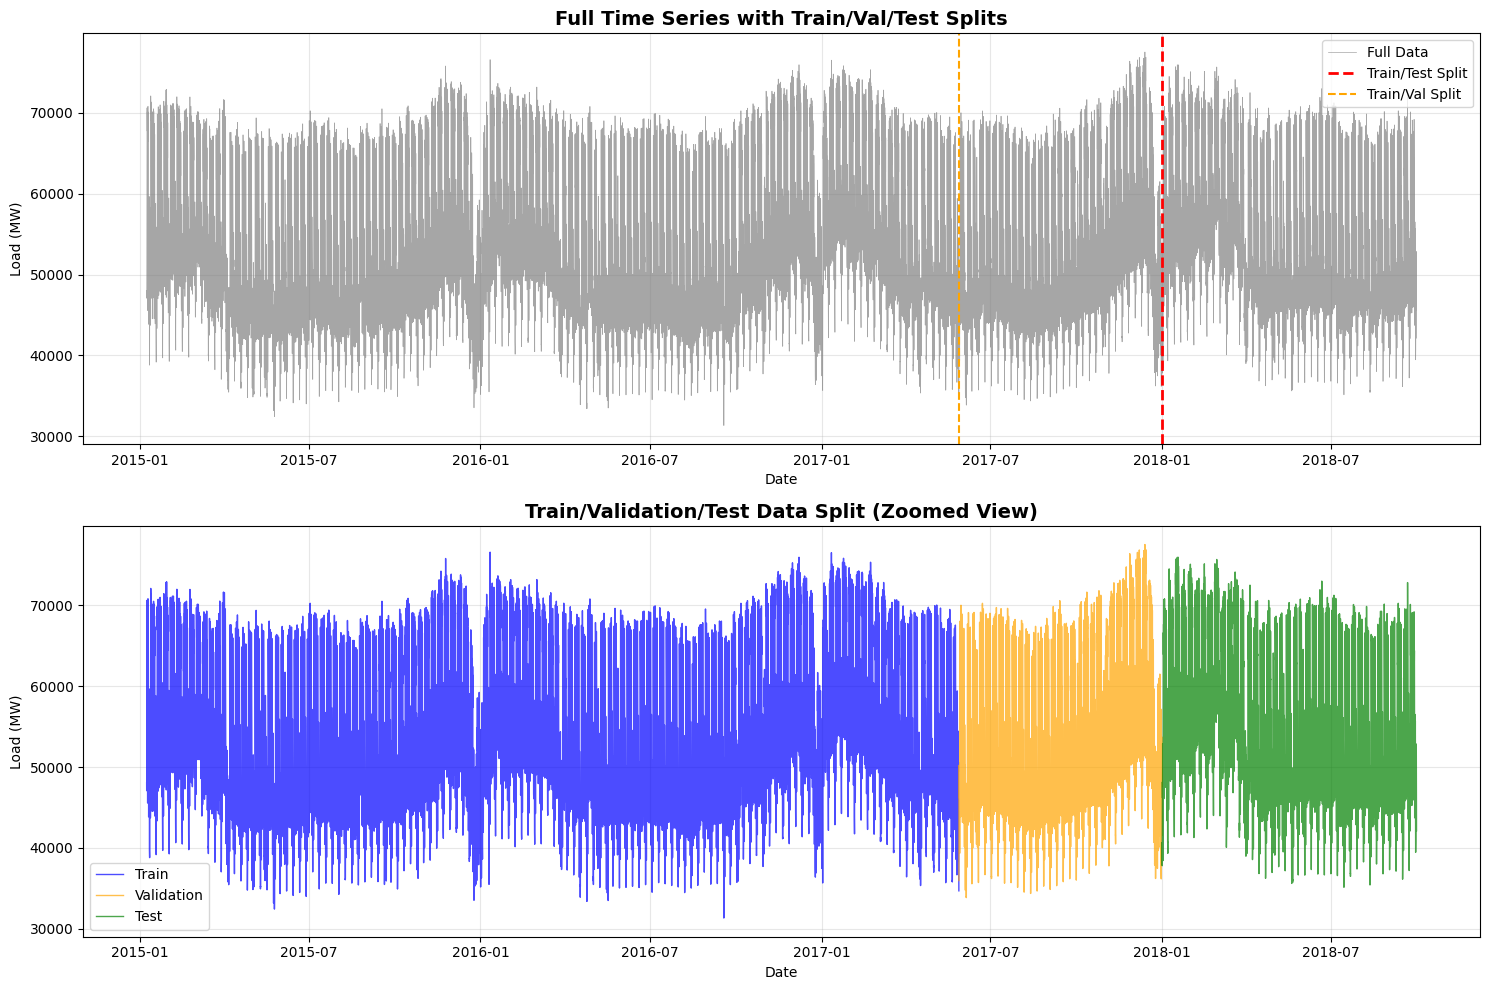

In [ ]:
# ==============================
# HYBRID SARIMA + LSTM (Residual Correction)
# ==============================

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

os.makedirs('../../saved_model_outputs/hybrid_outputs', exist_ok=True)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-9
    return float(np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100)

def create_sequences(X, y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# ------------------------------
# 1) Load data
# ------------------------------
DATA_PATH = "../processed_data_60min/processed_data_60min.csv" 

try:
    df = pd.read_csv(DATA_PATH, parse_dates=["utc_timestamp"], index_col="utc_timestamp")
except (ValueError, KeyError):
    df = pd.read_csv(DATA_PATH, parse_dates=[0], index_col=0)
    if df.index.name is None or df.index.name == "Unnamed: 0":
        df.index.name = "utc_timestamp"

df = df.sort_index()

target_col = "target_load"
feature_cols = [c for c in df.columns if c != target_col]

print(f"Loaded df: {df.shape}")
print(f"Date range: {df.index.min()} -> {df.index.max()}")
print(f"#features: {len(feature_cols)}")

# ------------------------------
# 2) Train/Val/Test split
# ------------------------------
train_end_date = "2017-12-31 23:00:00"
test_start_date = "2018-01-01 00:00:00"

train_full = df.loc[:train_end_date].copy()
test_df    = df.loc[test_start_date:].copy()

# Internal validation split: last 20% of train_full as validation (time-based)
val_split_idx = int(0.80 * len(train_full))
train_df = train_full.iloc[:val_split_idx].copy()
val_df   = train_full.iloc[val_split_idx:].copy()

train_series_full = train_full[target_col].astype(float)
test_series = test_df[target_col].astype(float)

if train_series_full.index.freq is None:
    inferred_freq = pd.infer_freq(train_series_full.index)
    if inferred_freq is not None:
        train_series_full.index.freq = inferred_freq
        test_series.index.freq = inferred_freq

print(f"Training samples: {len(train_series_full):,}")
print(f"Test samples: {len(test_series):,}")

print(f"Train full: {train_full.index.min()} -> {train_full.index.max()} | n={len(train_full)}")
print(f"Train    : {train_df.index.min()} -> {train_df.index.max()} | n={len(train_df)}")
print(f"Val      : {val_df.index.min()} -> {val_df.index.max()} | n={len(val_df)}")
print(f"Test     : {test_df.index.min()} -> {test_df.index.max()} | n={len(test_df)}")

In [ ]:

# ------------------------------
# 3) SARIMA (univariate)
# ------------------------------
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)  # weekly seasonality for hourly data

sarima = ARIMA(train_series_full, order=order, seasonal_order=seasonal_order).fit(low_memory=True)
print(sarima.summary())

# SARIMA fitted values (train_full) and forecasts (test)
sarima_fitted = sarima.fittedvalues.reindex(train_full.index)

sarima_forecast = sarima.get_forecast(steps=len(test_series)).predicted_mean
sarima_forecast.index = test_series.index

# Residuals (train_full and test)
resid_full = (train_series_full - sarima_fitted).dropna()
resid_test = (test_series - sarima_forecast).dropna()

# Split residuals to align with train_df/val_df
resid_train = resid_full.loc[train_df.index.intersection(resid_full.index)]
resid_val   = resid_full.loc[val_df.index.intersection(resid_full.index)]

print("Residual shapes:")
print("  resid_train:", resid_train.shape)
print("  resid_val  :", resid_val.shape)
print("  resid_test :", resid_test.shape)


                                    SARIMAX Results                                     
Dep. Variable:                      target_load   No. Observations:                26136
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -213430.445
Date:                          Mon, 12 Jan 2026   AIC                         426870.890
Time:                                  22:41:31   BIC                         426911.740
Sample:                              01-08-2015   HQIC                        426884.084
                                   - 12-31-2017                                         
Covariance Type:                         approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3867      0.008     48.322      0.000       0.371       0.402
ma.L1          0.3453      0.008     45.693      0.

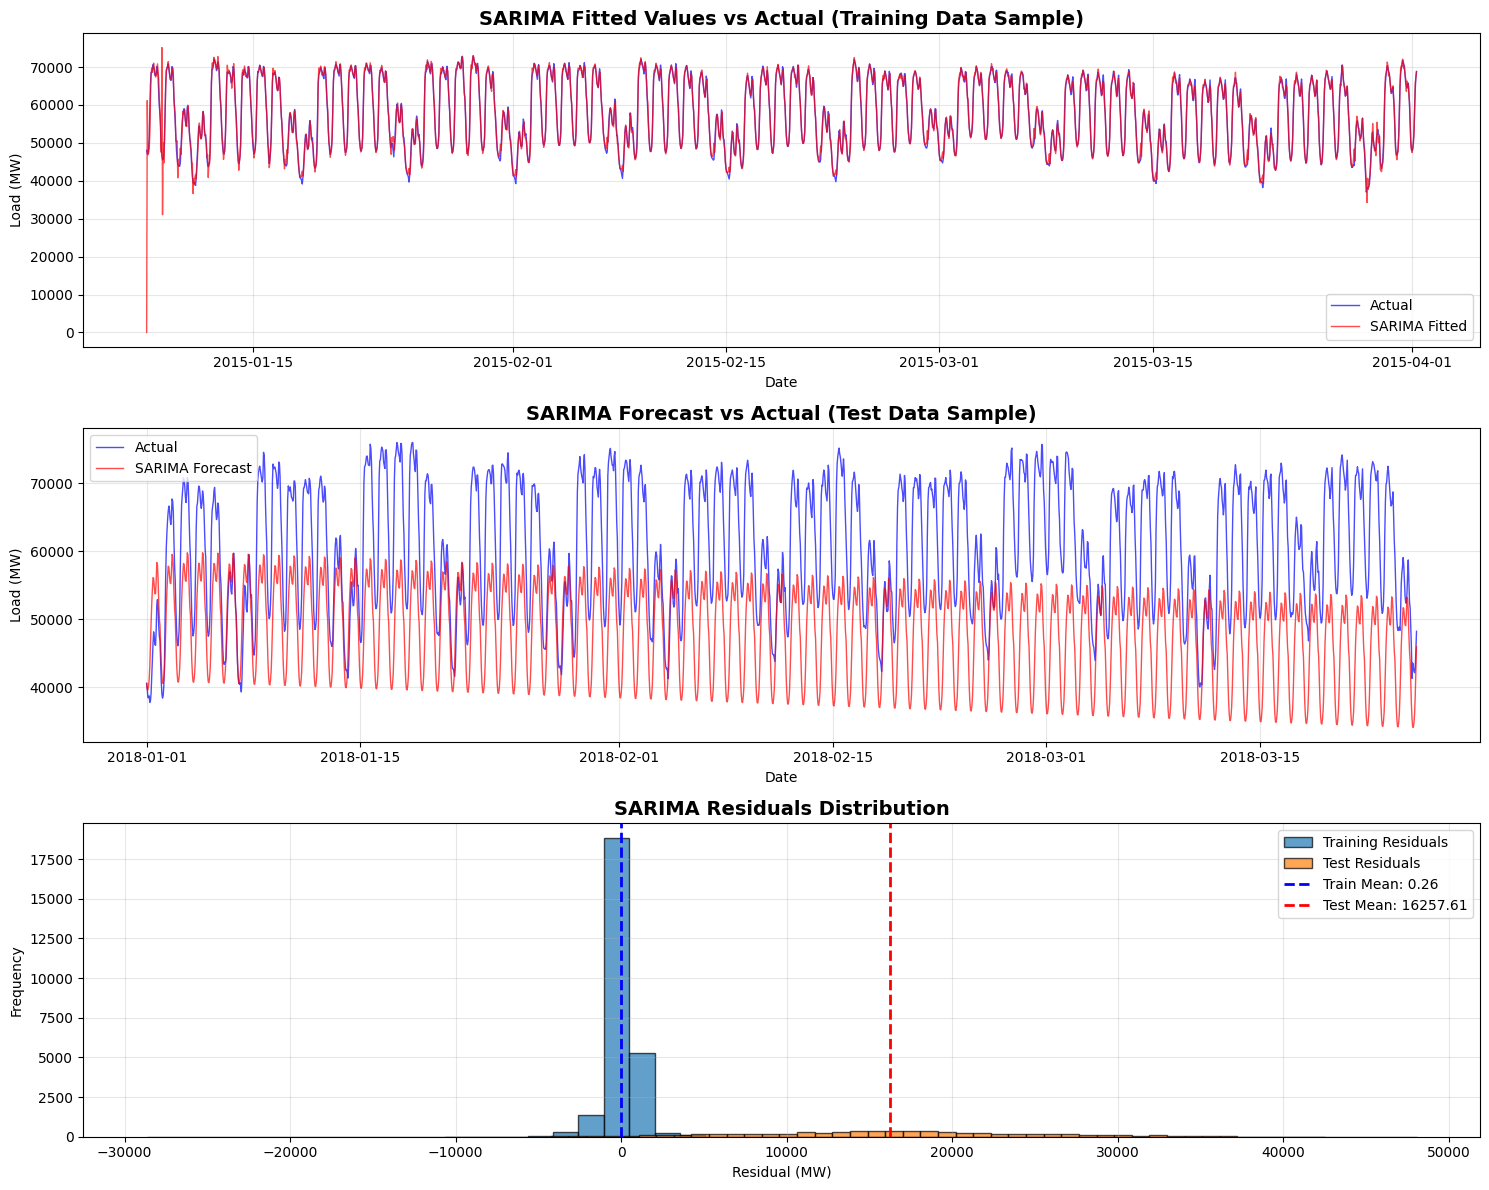

In [40]:
# Visualize SARIMA fitted values and residuals
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# SARIMA fitted vs actual (training)
sample_idx = slice(0, min(2000, len(train_series_full)))
axes[0].plot(train_series_full.index[sample_idx], train_series_full.values[sample_idx], 
             label='Actual', linewidth=1, alpha=0.7, color='blue')
axes[0].plot(sarima_fitted.index[sample_idx], sarima_fitted.values[sample_idx], 
             label='SARIMA Fitted', linewidth=1, alpha=0.7, color='red')
axes[0].set_title('SARIMA Fitted Values vs Actual (Training Data Sample)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# SARIMA forecast vs actual (test)
sample_idx_test = slice(0, min(2000, len(test_series)))
axes[1].plot(test_series.index[sample_idx_test], test_series.values[sample_idx_test], 
             label='Actual', linewidth=1, alpha=0.7, color='blue')
axes[1].plot(sarima_forecast.index[sample_idx_test], sarima_forecast.values[sample_idx_test], 
             label='SARIMA Forecast', linewidth=1, alpha=0.7, color='red')
axes[1].set_title('SARIMA Forecast vs Actual (Test Data Sample)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Load (MW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Residuals distribution
axes[2].hist(resid_full.values, bins=50, alpha=0.7, edgecolor='black', label='Training Residuals')
axes[2].hist(resid_test.values, bins=50, alpha=0.7, edgecolor='black', label='Test Residuals')
axes[2].axvline(resid_full.mean(), color='blue', linestyle='--', linewidth=2, label=f'Train Mean: {resid_full.mean():.2f}')
axes[2].axvline(resid_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Test Mean: {resid_test.mean():.2f}')
axes[2].set_title('SARIMA Residuals Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Residual (MW)')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/hybrid_outputs/02_sarima_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

Aligned matrices:
  X_train: (20908, 83) y_train: (20908, 1)
  X_val  : (5228, 83) y_val  : (5228, 1)
  X_test : (6552, 83) y_test : (6552, 1)
Sequence shapes:
  X_train_seq: (20884, 24, 83) y_train_seq: (20884,)
  X_val_seq  : (5204, 24, 83) y_val_seq  : (5204,)
  X_test_seq : (6528, 24, 83) y_test_seq : (6528,)


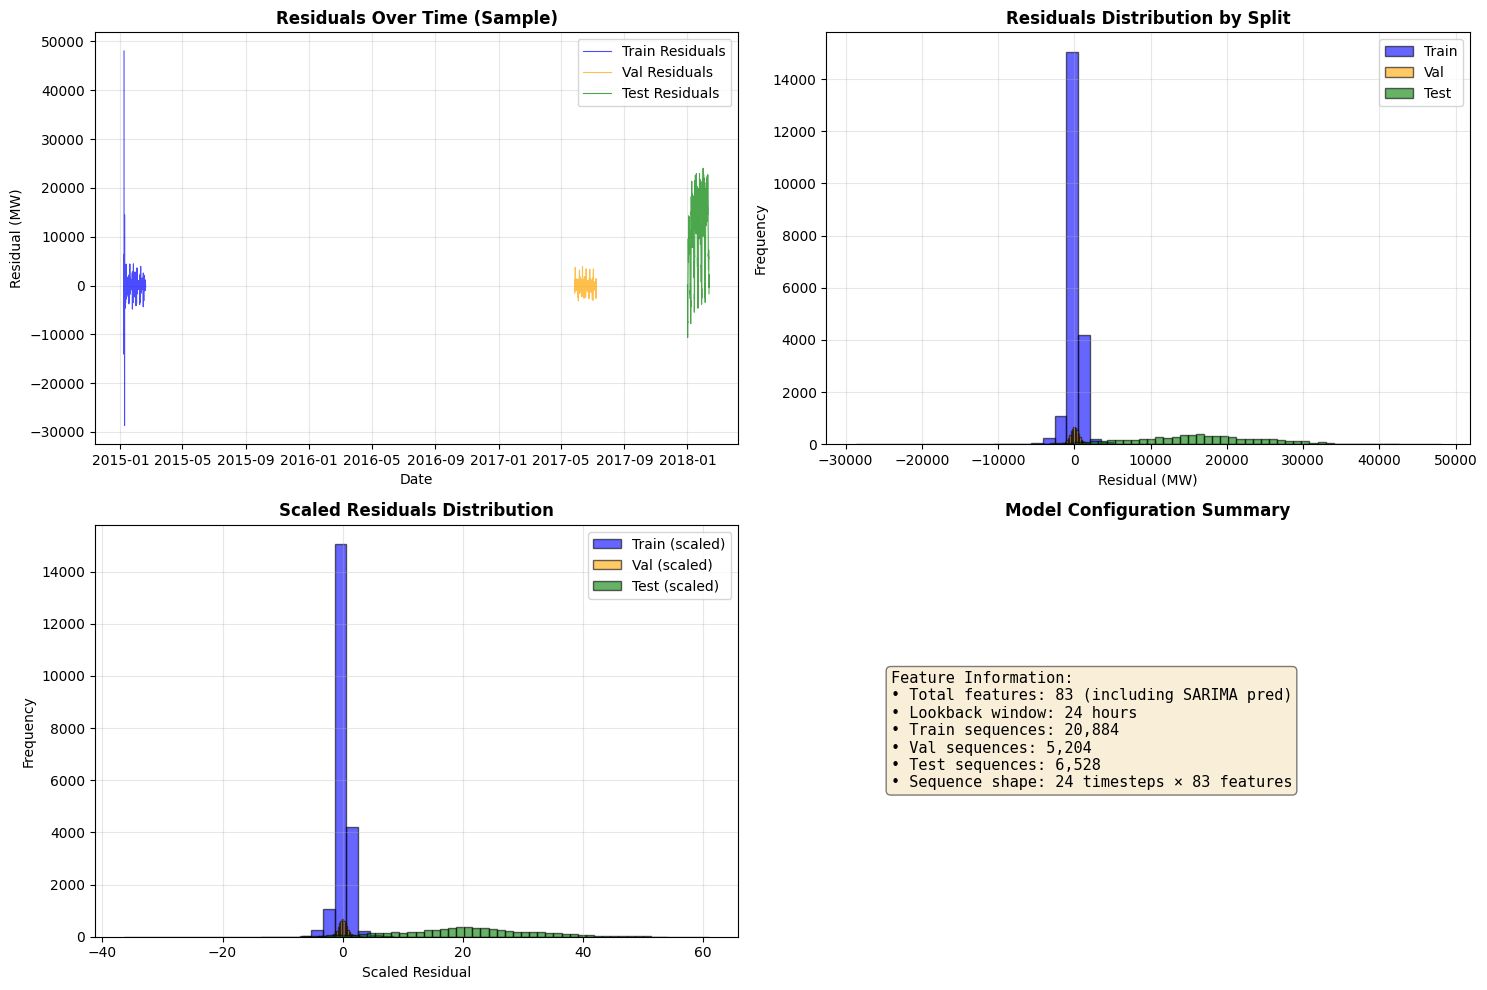

In [ ]:

# ------------------------------
# 4) Build feature matrices aligned to residual timestamps
# ------------------------------
X_train_df = train_df.loc[resid_train.index, feature_cols].copy()
X_val_df   = val_df.loc[resid_val.index, feature_cols].copy()
X_test_df  = test_df.loc[resid_test.index, feature_cols].copy()

# add SARIMA prediction as a feature to help correction
X_train_df["sarima_pred"] = sarima_fitted.loc[X_train_df.index]
X_val_df["sarima_pred"]   = sarima_fitted.loc[X_val_df.index]
X_test_df["sarima_pred"]  = sarima_forecast.loc[X_test_df.index]

# Align targets after dropping NaNs
y_train = resid_train.loc[X_train_df.index].values.reshape(-1, 1)
y_val   = resid_val.loc[X_val_df.index].values.reshape(-1, 1)
y_test  = resid_test.loc[X_test_df.index].values.reshape(-1, 1)

print("Aligned matrices:")
print("  X_train:", X_train_df.shape, "y_train:", y_train.shape)
print("  X_val  :", X_val_df.shape,   "y_val  :", y_val.shape)
print("  X_test :", X_test_df.shape,  "y_test :", y_test.shape)

# ------------------------------
# 5) Scale features and residual target
# ------------------------------
feature_scaler = RobustScaler()
resid_scaler = RobustScaler()

X_train_s = feature_scaler.fit_transform(X_train_df.values)
X_val_s   = feature_scaler.transform(X_val_df.values)
X_test_s  = feature_scaler.transform(X_test_df.values)

y_train_s = resid_scaler.fit_transform(y_train).flatten()
y_val_s   = resid_scaler.transform(y_val).flatten()
y_test_s  = resid_scaler.transform(y_test).flatten()

# ------------------------------
# 6) Create lookback seq
# ------------------------------
lookback = 24  # 24 hours = 1 day (match your LSTM-alone baseline)
X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, lookback )
X_val_seq,   y_val_seq   = create_sequences(X_val_s,   y_val_s,   lookback )
X_test_seq,  y_test_seq  = create_sequences(X_test_s,  y_test_s,  lookback )

print("Sequence shapes:")
print("  X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("  X_val_seq  :", X_val_seq.shape,   "y_val_seq  :", y_val_seq.shape)
print("  X_test_seq :", X_test_seq.shape,  "y_test_seq :", y_test_seq.shape)



In [6]:
# ------------------------------
# 7) Build residual LSTM model
# ------------------------------
tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train_seq.shape[2]
dropout_rate = 0.2

resid_model = Sequential([
    Input(shape=(lookback, n_features)),
    LSTM(64, return_sequences=True, dropout=dropout_rate),
    LSTM(32, return_sequences=False, dropout=dropout_rate),
    Dense(16, activation="relu"),
    Dropout(dropout_rate),
    Dense(1)  # Predict residual
])

resid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

resid_model.summary()

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint("../../saved_model_outputs/hybrid_outputs/best_residual_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history = resid_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,849 (198.63 KB)

 Trainable params: 50,849 (198.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3197 - mae: 0.7448
Epoch 1: val_loss improved from None to 0.90667, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 1: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1.2680 - mae: 0.7245 - val_loss: 0.9067 - val_mae: 0.6754 - learning_rate: 0.0010
Epoch 2/100
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1912 - mae: 0.7099
Epoch 2: val_loss improved from 0.90667 to 0.65381, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 2: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.1200 - mae: 0.6819 - val_loss: 0.6538 - val_mae: 0.5926 - learning_rate: 0.0010
Epoch 3/100
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9831 - mae: 0.6462
Epoch 3: val_loss improved from 0.65381 to 0.59418, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 3: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9418 - mae: 0.6255 - val_loss: 0.5942 - val_mae: 0.5594 - learning_rate: 0.0010
Epoch 4/100
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8807 - mae: 0.6054
Epoch 4: val_loss improved from 0.59418 to 0.53236, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 4: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8621 - mae: 0.5951 - val_loss: 0.5324 - val_mae: 0.5351 - learning_rate: 0.0010
Epoch 5/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8404 - mae: 0.5957
Epoch 5: val_loss improved from 0.53236 to 0.52907, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 5: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8257 - mae: 0.5851 - val_loss: 0.5291 - val_mae: 0.5331 - learning_rate: 0.0010
Epoch 6/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8169 - mae: 0.5883
Epoch 6: val_loss improved from 0.52907 to 0.51262, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 6: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8006 - mae: 0.5774 - val_loss: 0.5126 - val_mae: 0.5300 - learning_rate: 0.0010
Epoch 7/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7837 - mae: 0.5766
Epoch 7: val_loss improved from 0.51262 to 0.50318, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 7: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7846 - mae: 0.5710 - val_loss: 0.5032 - val_mae: 0.5239 - learning_rate: 0.0010
Epoch 8/100
321/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7589 - mae: 0.5688
Epoch 8: val_loss improved from 0.50318 to 0.49178, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 8: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7643 - mae: 0.5651 - val_loss: 0.4918 - val_mae: 0.5211 - learning_rate: 0.0010
Epoch 9/100
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7521 - mae: 0.5686
Epoch 9: val_loss did not improve from 0.49178
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7663 - mae: 0.5651 - val_loss: 0.4937 - val_mae: 0.5215 - learning_rate: 0.0010
Epoch 10/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7567 - mae: 0.5682
Epoch 10: val_loss improved from 0.49178 to 0.48561, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 10: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7561 - mae: 0.5607 - val_loss: 0.4856 - val_mae: 0.5176 - learning_rate: 0.0010
Epoch 11/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7363 - mae: 0.5617
Epoch 11: val_loss improved from 0.48561 to 0.47605, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 11: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7448 - mae: 0.5569 - val_loss: 0.4761 - val_mae: 0.5138 - learning_rate: 0.0010
Epoch 12/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7229 - mae: 0.5569
Epoch 12: val_loss did not improve from 0.47605
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.7345 - mae: 0.5531 - val_loss: 0.4822 - val_mae: 0.5143 - learning_rate: 0.0010
Epoch 13/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7314 - mae: 0.5588
Epoch 13: val_loss did not improve from 0.47605
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7400 - mae: 0.5544 - val_loss: 0.4876 - val_mae: 0.5208 - learning_rate: 0.0010
Epoch 14/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7194 - mae: 0.5552
Epoch 14: val_loss did not improve from 0.47605
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7248 - mae: 0.5494 - val_loss: 0.4775 - val_mae: 0.5159 


Epoch 15: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7243 - mae: 0.5469 - val_loss: 0.4610 - val_mae: 0.5096 - learning_rate: 0.0010
Epoch 16/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7167 - mae: 0.5505
Epoch 16: val_loss improved from 0.46096 to 0.45853, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 16: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7286 - mae: 0.5486 - val_loss: 0.4585 - val_mae: 0.5037 - learning_rate: 0.0010
Epoch 17/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7058 - mae: 0.5452
Epoch 17: val_loss improved from 0.45853 to 0.45124, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 17: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7137 - mae: 0.5424 - val_loss: 0.4512 - val_mae: 0.5014 - learning_rate: 0.0010
Epoch 18/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7009 - mae: 0.5455
Epoch 18: val_loss improved from 0.45124 to 0.44480, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 18: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7127 - mae: 0.5412 - val_loss: 0.4448 - val_mae: 0.5019 - learning_rate: 0.0010
Epoch 19/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7140 - mae: 0.5456
Epoch 19: val_loss did not improve from 0.44480
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7093 - mae: 0.5385 - val_loss: 0.4535 - val_mae: 0.5011 - learning_rate: 0.0010
Epoch 20/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6956 - mae: 0.5412
Epoch 20: val_loss improved from 0.44480 to 0.43456, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 20: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6998 - mae: 0.5359 - val_loss: 0.4346 - val_mae: 0.4955 - learning_rate: 0.0010
Epoch 21/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6826 - mae: 0.5348
Epoch 21: val_loss improved from 0.43456 to 0.42985, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 21: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6883 - mae: 0.5302 - val_loss: 0.4299 - val_mae: 0.4935 - learning_rate: 0.0010
Epoch 22/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6750 - mae: 0.5337
Epoch 22: val_loss did not improve from 0.42985
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6794 - mae: 0.5281 - val_loss: 0.4351 - val_mae: 0.4953 - learning_rate: 0.0010
Epoch 23/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6782 - mae: 0.5351
Epoch 23: val_loss improved from 0.42985 to 0.42581, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 23: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6855 - mae: 0.5302 - val_loss: 0.4258 - val_mae: 0.4884 - learning_rate: 0.0010
Epoch 24/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6612 - mae: 0.5264
Epoch 24: val_loss improved from 0.42581 to 0.42125, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 24: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6668 - mae: 0.5214 - val_loss: 0.4213 - val_mae: 0.4813 - learning_rate: 0.0010
Epoch 25/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6493 - mae: 0.5224
Epoch 25: val_loss improved from 0.42125 to 0.41448, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 25: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6577 - mae: 0.5184 - val_loss: 0.4145 - val_mae: 0.4814 - learning_rate: 0.0010
Epoch 26/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6486 - mae: 0.5227
Epoch 26: val_loss improved from 0.41448 to 0.39411, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 26: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6483 - mae: 0.5154 - val_loss: 0.3941 - val_mae: 0.4695 - learning_rate: 0.0010
Epoch 27/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6383 - mae: 0.5154
Epoch 27: val_loss improved from 0.39411 to 0.39073, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 27: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6464 - mae: 0.5122 - val_loss: 0.3907 - val_mae: 0.4660 - learning_rate: 0.0010
Epoch 28/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6144 - mae: 0.5084
Epoch 28: val_loss improved from 0.39073 to 0.38360, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 28: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6134 - mae: 0.5019 - val_loss: 0.3836 - val_mae: 0.4633 - learning_rate: 0.0010
Epoch 29/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6093 - mae: 0.5020
Epoch 29: val_loss improved from 0.38360 to 0.37230, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 29: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.6083 - mae: 0.4985 - val_loss: 0.3723 - val_mae: 0.4551 - learning_rate: 0.0010
Epoch 30/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6019 - mae: 0.5007
Epoch 30: val_loss improved from 0.37230 to 0.36931, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 30: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6032 - mae: 0.4959 - val_loss: 0.3693 - val_mae: 0.4521 - learning_rate: 0.0010
Epoch 31/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5854 - mae: 0.4934
Epoch 31: val_loss did not improve from 0.36931
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5842 - mae: 0.4875 - val_loss: 0.3822 - val_mae: 0.4565 - learning_rate: 0.0010
Epoch 32/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5883 - mae: 0.4948
Epoch 32: val_loss did not improve from 0.36931
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5849 - mae: 0.4890 - val_loss: 0.3796 - val_mae: 0.4520 - learning_rate: 0.0010
Epoch 33/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5793 - mae: 0.4875
Epoch 33: val_loss improved from 0.36931 to 0.35088, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 33: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5785 - mae: 0.4825 - val_loss: 0.3509 - val_mae: 0.4416 - learning_rate: 0.0010
Epoch 34/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5718 - mae: 0.4863
Epoch 34: val_loss did not improve from 0.35088
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5667 - mae: 0.4798 - val_loss: 0.3688 - val_mae: 0.4455 - learning_rate: 0.0010
Epoch 35/100
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5694 - mae: 0.4860
Epoch 35: val_loss did not improve from 0.35088
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5641 - mae: 0.4787 - val_loss: 0.3511 - val_mae: 0.4400 - learning_rate: 0.0010
Epoch 36/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5552 - mae: 0.4796
Epoch 36: val_loss improved from 0.35088 to 0.34983, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 36: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5600 - mae: 0.4765 - val_loss: 0.3498 - val_mae: 0.4386 - learning_rate: 0.0010
Epoch 37/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5570 - mae: 0.4826
Epoch 37: val_loss did not improve from 0.34983
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5688 - mae: 0.4778 - val_loss: 0.3657 - val_mae: 0.4448 - learning_rate: 0.0010
Epoch 38/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5494 - mae: 0.4757
Epoch 38: val_loss did not improve from 0.34983
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5525 - mae: 0.4710 - val_loss: 0.3505 - val_mae: 0.4377 - learning_rate: 0.0010
Epoch 39/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5519 - mae: 0.4790
Epoch 39: val_loss did not improve from 0.34983
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5556 - mae: 0.4747 - val_loss: 0.3503 - val_mae: 0.4401 


Epoch 40: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5358 - mae: 0.4697 - val_loss: 0.3486 - val_mae: 0.4390 - learning_rate: 0.0010
Epoch 41/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5256 - mae: 0.4723
Epoch 41: val_loss improved from 0.34859 to 0.34140, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 41: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5320 - mae: 0.4670 - val_loss: 0.3414 - val_mae: 0.4349 - learning_rate: 0.0010
Epoch 42/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5406 - mae: 0.4739
Epoch 42: val_loss did not improve from 0.34140
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5467 - mae: 0.4695 - val_loss: 0.3422 - val_mae: 0.4354 - learning_rate: 0.0010
Epoch 43/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5257 - mae: 0.4708
Epoch 43: val_loss improved from 0.34140 to 0.34029, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 43: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5267 - mae: 0.4652 - val_loss: 0.3403 - val_mae: 0.4355 - learning_rate: 0.0010
Epoch 44/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5254 - mae: 0.4733
Epoch 44: val_loss did not improve from 0.34029
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5282 - mae: 0.4677 - val_loss: 0.3433 - val_mae: 0.4356 - learning_rate: 0.0010
Epoch 45/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5220 - mae: 0.4726
Epoch 45: val_loss did not improve from 0.34029
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5183 - mae: 0.4655 - val_loss: 0.3411 - val_mae: 0.4340 - learning_rate: 0.0010
Epoch 46/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5122 - mae: 0.4697
Epoch 46: val_loss did not improve from 0.34029
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5084 - mae: 0.4630 - val_loss: 0.3404 - val_mae: 0.4334 


Epoch 49: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4844 - mae: 0.4535 - val_loss: 0.3384 - val_mae: 0.4332 - learning_rate: 5.0000e-04
Epoch 50/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4682 - mae: 0.4512
Epoch 50: val_loss improved from 0.33843 to 0.33759, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 50: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4778 - mae: 0.4502 - val_loss: 0.3376 - val_mae: 0.4320 - learning_rate: 5.0000e-04
Epoch 51/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4720 - mae: 0.4529
Epoch 51: val_loss did not improve from 0.33759
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4755 - mae: 0.4505 - val_loss: 0.3383 - val_mae: 0.4322 - learning_rate: 5.0000e-04
Epoch 52/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4861 - mae: 0.4554
Epoch 52: val_loss improved from 0.33759 to 0.33364, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 52: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4799 - mae: 0.4498 - val_loss: 0.3336 - val_mae: 0.4303 - learning_rate: 5.0000e-04
Epoch 53/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4746 - mae: 0.4580
Epoch 53: val_loss improved from 0.33364 to 0.33297, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 53: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4730 - mae: 0.4495 - val_loss: 0.3330 - val_mae: 0.4301 - learning_rate: 5.0000e-04
Epoch 54/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4626 - mae: 0.4496
Epoch 54: val_loss improved from 0.33297 to 0.33173, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 54: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4612 - mae: 0.4469 - val_loss: 0.3317 - val_mae: 0.4296 - learning_rate: 5.0000e-04
Epoch 55/100
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4739 - mae: 0.4557
Epoch 55: val_loss improved from 0.33173 to 0.33102, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 55: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.4723 - mae: 0.4489 - val_loss: 0.3310 - val_mae: 0.4285 - learning_rate: 5.0000e-04
Epoch 56/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4603 - mae: 0.4537
Epoch 56: val_loss did not improve from 0.33102
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4721 - mae: 0.4508 - val_loss: 0.3411 - val_mae: 0.4322 - learning_rate: 5.0000e-04
Epoch 57/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4689 - mae: 0.4514
Epoch 57: val_loss did not improve from 0.33102
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4691 - mae: 0.4481 - val_loss: 0.3331 - val_mae: 0.4305 - learning_rate: 5.0000e-04
Epoch 58/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4423 - mae: 0.4479
Epoch 58: val_loss did not improve from 0.33102
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4530 - mae: 0.4458 - val_loss: 0.3366 - val_


Epoch 62: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4423 - mae: 0.4407 - val_loss: 0.3308 - val_mae: 0.4285 - learning_rate: 2.5000e-04
Epoch 63/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4417 - mae: 0.4432
Epoch 63: val_loss improved from 0.33075 to 0.32989, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 63: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4404 - mae: 0.4393 - val_loss: 0.3299 - val_mae: 0.4280 - learning_rate: 2.5000e-04
Epoch 64/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4320 - mae: 0.4444
Epoch 64: val_loss did not improve from 0.32989
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.4327 - mae: 0.4409 - val_loss: 0.3301 - val_mae: 0.4275 - learning_rate: 2.5000e-04
Epoch 65/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4317 - mae: 0.4411
Epoch 65: val_loss did not improve from 0.32989
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.4317 - mae: 0.4396 - val_loss: 0.3320 - val_mae: 0.4279 - learning_rate: 2.5000e-04
Epoch 66/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4345 - mae: 0.4424
Epoch 66: val_loss did not improve from 0.32989
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.4345 - mae: 0.4383 - val_loss: 0.3345 - val_


Epoch 67: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.4442 - mae: 0.4436 - val_loss: 0.3290 - val_mae: 0.4265 - learning_rate: 2.5000e-04
Epoch 68/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4519 - mae: 0.4429
Epoch 68: val_loss improved from 0.32902 to 0.32801, saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5



Epoch 68: finished saving model to ../../saved_model_outputs/hybrid_outputs/best_residual_model.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.4554 - mae: 0.4407 - val_loss: 0.3280 - val_mae: 0.4265 - learning_rate: 2.5000e-04
Epoch 69/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4477 - mae: 0.4446
Epoch 69: val_loss did not improve from 0.32801
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.4463 - mae: 0.4406 - val_loss: 0.3313 - val_mae: 0.4283 - learning_rate: 2.5000e-04
Epoch 70/100
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4332 - mae: 0.4401
Epoch 70: val_loss did not improve from 0.32801
327/327 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.4385 - mae: 0.4390 - val_loss: 0.3311 - val_mae: 0.4283 - learning_rate: 2.5000e-04
Epoch 71/100
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4331 - mae: 0.4424
Epoch 71: val_loss did not improve from 0.32801
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.4347 - mae: 0.4390 - val_loss: 0.3334 - val_

In [7]:
# ------------------------------
# 8) Predict residuals on test set and form hybrid forecast
# ------------------------------
resid_pred_s = resid_model.predict(X_test_seq, verbose=0).flatten()
resid_pred = resid_scaler.inverse_transform(resid_pred_s.reshape(-1, 1)).flatten()

# Align timestamps for hybrid (sequence length offset)
# X_test_df index corresponds to y_test timestamps; sequence shifts by lookback
test_index = X_test_df.index
hybrid_index = test_index[lookback:lookback + len(resid_pred)]

sarima_fc_aligned = sarima_forecast.loc[hybrid_index]
actual_aligned = test_series.loc[hybrid_index]

hybrid_pred = sarima_fc_aligned.values + resid_pred



HYBRID PERFORMANCE (Aligned with SARIMA & LSTM pipeline)

=== SARIMA ===
MAE  : 16,444.76
RMSE : 18,423.25
MAPE : 28.65%

=== HYBRID (SARIMA + LSTM-residual) ===
MAE  : 16,475.40
RMSE : 18,460.52
MAPE : 28.70%

=== IMPROVEMENT OVER SARIMA ===
MAE  improvement : -0.19%
RMSE improvement : -0.20%

PEAK PERFORMANCE (Top 10% of demand in aligned test window)
Peak threshold (p90): 69,295.30 MW | Peak hours: 653 (10.0%)

Peak SARIMA:
  MAE : 19,718.49
  RMSE: 20,301.11

Peak HYBRID:
  MAE : 19,796.04
  RMSE: 20,382.12

Peak error variance SARIMA: 23352138.55456117
Peak error variance HYBRID: 23583926.35946645
Peak error std      SARIMA: 4832.405048685507
Peak error std      HYBRID: 4856.32848553992


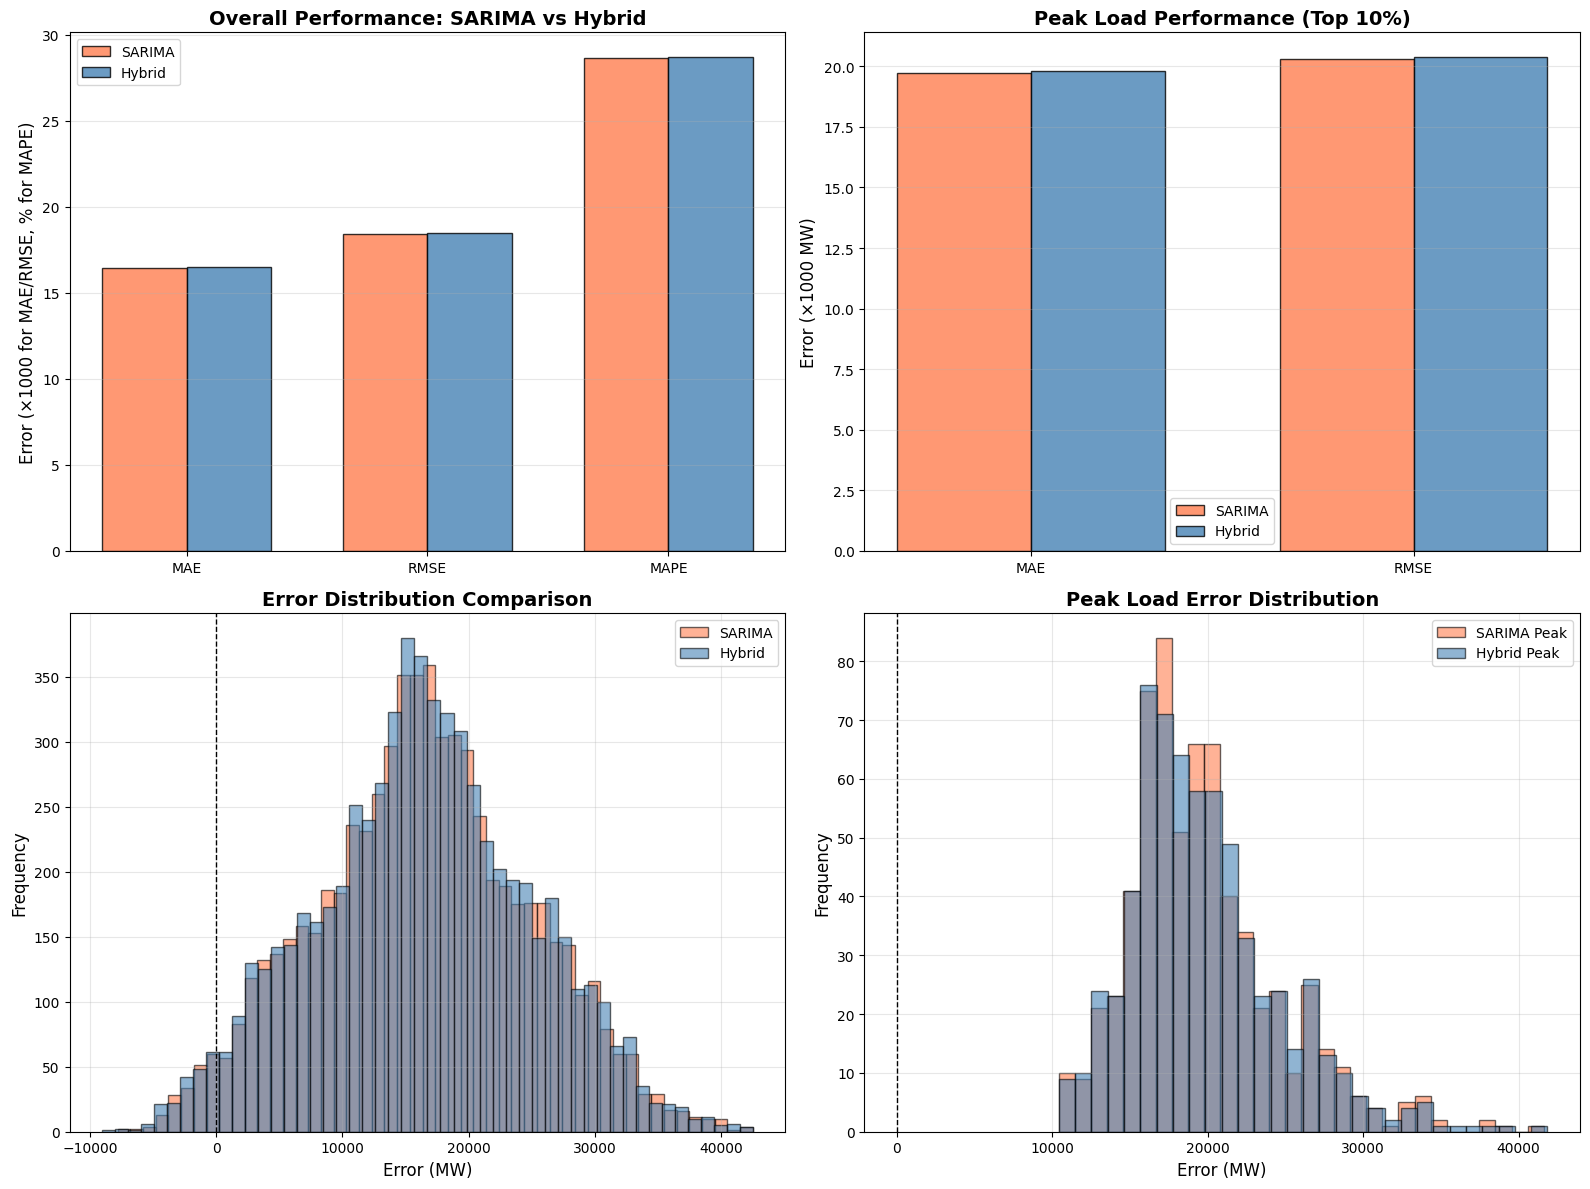

In [42]:

# ------------------------------
# 9) Evaluate: overall + peak hours (90th percentile)
# ------------------------------
print("\n" + "="*80)
print("HYBRID PERFORMANCE (Aligned with SARIMA & LSTM pipeline)")
print("="*80)

# Overall
sarima_mae = mean_absolute_error(actual_aligned, sarima_fc_aligned)
sarima_rmse = rmse(actual_aligned, sarima_fc_aligned)
sarima_mape = mape(actual_aligned, sarima_fc_aligned)

hyb_mae = mean_absolute_error(actual_aligned, hybrid_pred)
hyb_rmse = rmse(actual_aligned, hybrid_pred)
hyb_mape = mape(actual_aligned, hybrid_pred)

print("\n=== SARIMA ===")
print(f"MAE  : {sarima_mae:,.2f}")
print(f"RMSE : {sarima_rmse:,.2f}")
print(f"MAPE : {sarima_mape:.2f}%")

print("\n=== HYBRID (SARIMA + LSTM-residual) ===")
print(f"MAE  : {hyb_mae:,.2f}")
print(f"RMSE : {hyb_rmse:,.2f}")
print(f"MAPE : {hyb_mape:.2f}%")

print("\n=== IMPROVEMENT OVER SARIMA ===")
print(f"MAE  improvement : {(sarima_mae - hyb_mae)/sarima_mae*100:.2f}%")
print(f"RMSE improvement : {(sarima_rmse - hyb_rmse)/sarima_rmse*100:.2f}%")

# Peak evaluation (top 10% of actual)
p90 = np.percentile(actual_aligned.values, 90)
is_peak = actual_aligned.values >= p90

peak_mae_s = mean_absolute_error(actual_aligned.values[is_peak], sarima_fc_aligned.values[is_peak])
peak_rmse_s = rmse(actual_aligned.values[is_peak], sarima_fc_aligned.values[is_peak])

peak_mae_h = mean_absolute_error(actual_aligned.values[is_peak], hybrid_pred[is_peak])
peak_rmse_h = rmse(actual_aligned.values[is_peak], hybrid_pred[is_peak])

print("\n" + "="*80)
print("PEAK PERFORMANCE (Top 10% of demand in aligned test window)")
print("="*80)
print(f"Peak threshold (p90): {p90:,.2f} MW | Peak hours: {is_peak.sum():,} ({is_peak.mean()*100:.1f}%)")

print("\nPeak SARIMA:")
print(f"  MAE : {peak_mae_s:,.2f}")
print(f"  RMSE: {peak_rmse_s:,.2f}")

print("\nPeak HYBRID:")
print(f"  MAE : {peak_mae_h:,.2f}")
print(f"  RMSE: {peak_rmse_h:,.2f}")

# Peak error variance (stability)
sarima_err_peak = actual_aligned.values[is_peak] - sarima_fc_aligned.values[is_peak]
hybrid_err_peak = actual_aligned.values[is_peak] - hybrid_pred[is_peak]

print("\nPeak error variance SARIMA:", float(np.var(sarima_err_peak, ddof=1)))
print("Peak error variance HYBRID:", float(np.var(hybrid_err_peak, ddof=1)))
print("Peak error std      SARIMA:", float(np.std(sarima_err_peak, ddof=1)))
print("Peak error std      HYBRID:", float(np.std(hybrid_err_peak, ddof=1)))

# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall metrics comparison
metrics_names = ['MAE', 'RMSE', 'MAPE']
sarima_metrics = [sarima_mae, sarima_rmse, sarima_mape]
hybrid_metrics = [hyb_mae, hyb_rmse, hyb_mape]

x = np.arange(len(metrics_names))
width = 0.35
axes[0, 0].bar(x - width/2, [m/1000 if i < 2 else m for i, m in enumerate(sarima_metrics)], 
               width, label='SARIMA', alpha=0.8, color='coral', edgecolor='black')
axes[0, 0].bar(x + width/2, [m/1000 if i < 2 else m for i, m in enumerate(hybrid_metrics)], 
               width, label='Hybrid', alpha=0.8, color='steelblue', edgecolor='black')
axes[0, 0].set_ylabel('Error (×1000 for MAE/RMSE, % for MAPE)', fontsize=12)
axes[0, 0].set_title('Overall Performance: SARIMA vs Hybrid', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_names)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Peak metrics comparison
peak_metrics_names = ['MAE', 'RMSE']
peak_sarima = [peak_mae_s, peak_rmse_s]
peak_hybrid = [peak_mae_h, peak_rmse_h]

x2 = np.arange(len(peak_metrics_names))
axes[0, 1].bar(x2 - width/2, [m/1000 for m in peak_sarima], width, label='SARIMA', 
               alpha=0.8, color='coral', edgecolor='black')
axes[0, 1].bar(x2 + width/2, [m/1000 for m in peak_hybrid], width, label='Hybrid', 
               alpha=0.8, color='steelblue', edgecolor='black')
axes[0, 1].set_ylabel('Error (×1000 MW)', fontsize=12)
axes[0, 1].set_title('Peak Load Performance (Top 10%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x2)
axes[0, 1].set_xticklabels(peak_metrics_names)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Error distribution comparison
all_errors_sarima = actual_aligned.values - sarima_fc_aligned.values
all_errors_hybrid = actual_aligned.values - hybrid_pred

axes[1, 0].hist(all_errors_sarima, bins=50, alpha=0.6, label='SARIMA', edgecolor='black', color='coral')
axes[1, 0].hist(all_errors_hybrid, bins=50, alpha=0.6, label='Hybrid', edgecolor='black', color='steelblue')
axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Error (MW)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Error Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Peak error distribution
axes[1, 1].hist(sarima_err_peak, bins=30, alpha=0.6, label='SARIMA Peak', edgecolor='black', color='coral')
axes[1, 1].hist(hybrid_err_peak, bins=30, alpha=0.6, label='Hybrid Peak', edgecolor='black', color='steelblue')
axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Error (MW)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Peak Load Error Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/hybrid_outputs/04_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


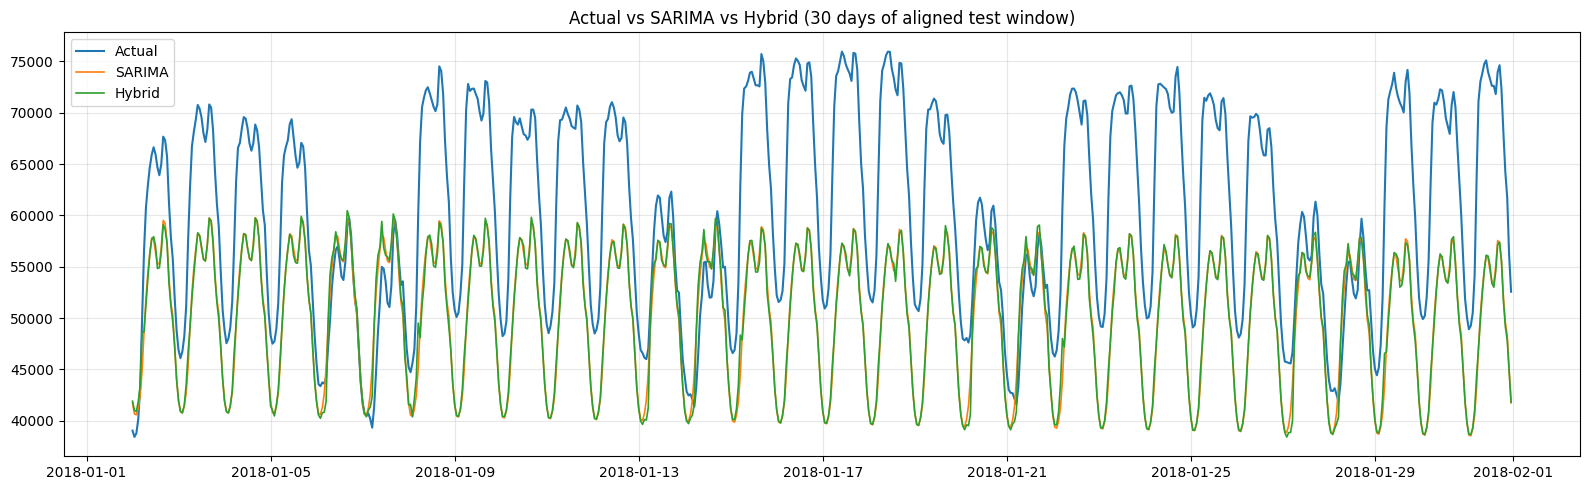

In [43]:
# ------------------------------
# 10) Plots (overall sample + peak subset)
# ------------------------------
# Plot a continuous slice for clarity (first 30 days)
plot_len = min(len(actual_aligned), 24*30)
plot_df = pd.DataFrame({
    "actual": actual_aligned.iloc[:plot_len].values,
    "sarima": sarima_fc_aligned.iloc[:plot_len].values,
    "hybrid": hybrid_pred[:plot_len]
}, index=actual_aligned.index[:plot_len])

plt.figure(figsize=(16, 5))
plt.plot(plot_df.index, plot_df["actual"], label="Actual", linewidth=1.5)
plt.plot(plot_df.index, plot_df["sarima"], label="SARIMA", linewidth=1.2)
plt.plot(plot_df.index, plot_df["hybrid"], label="Hybrid", linewidth=1.2)
plt.title("Actual vs SARIMA vs Hybrid (30 days of aligned test window)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../../saved_model_outputs/hybrid_outputs/hybrid_timeseries_first30days.png", dpi=300)
plt.show()

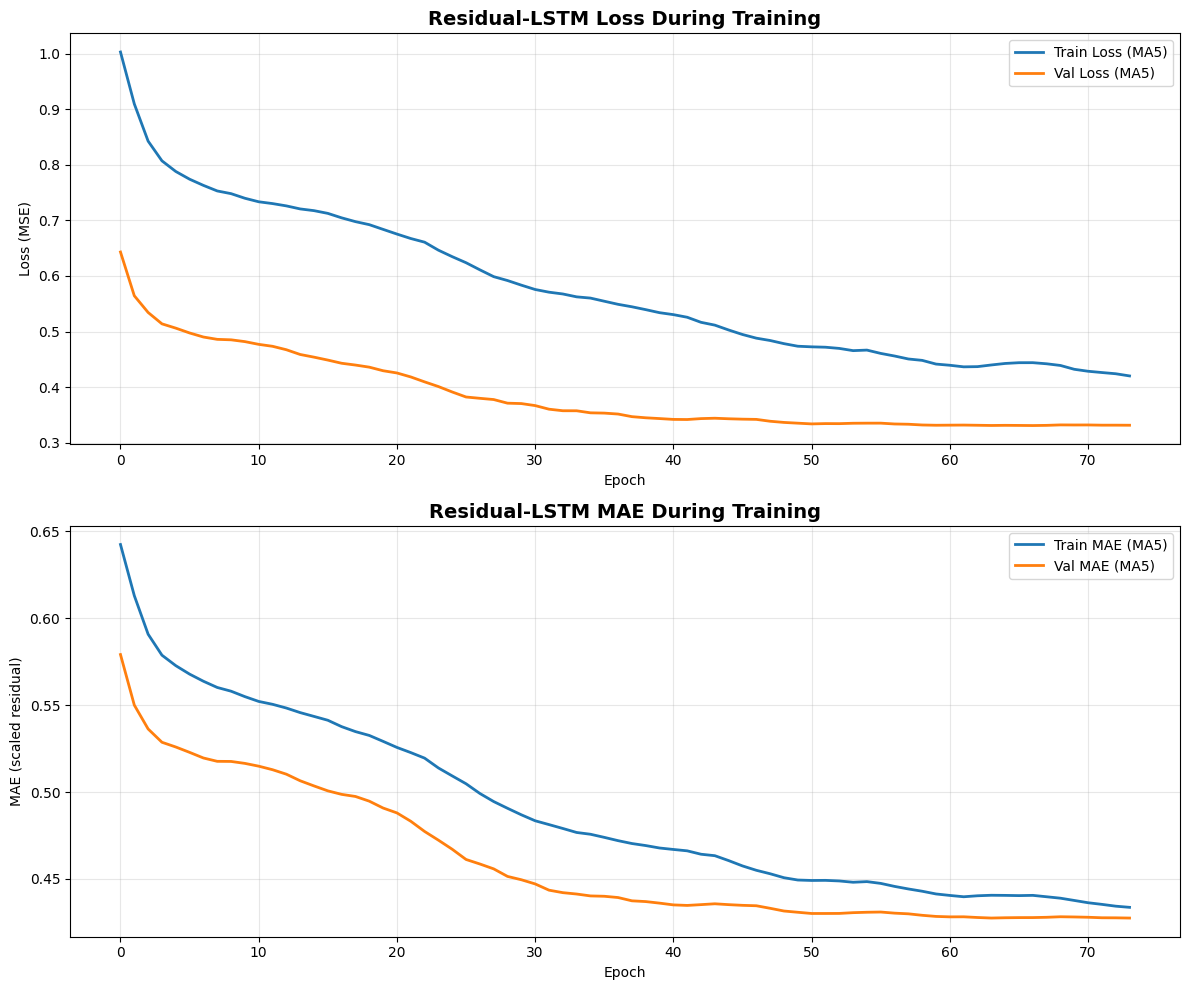

Saved training history to ../../saved_model_outputs/hybrid_outputs/training_history_hybrid.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smooth(y, window=5):
    y = np.asarray(y, dtype=float)
    if len(y) < window:
        return y
    return np.convolve(y, np.ones(window)/window, mode="valid")

loss = history.history["loss"]
val_loss = history.history["val_loss"]

mae = history.history.get("mae", None)
val_mae = history.history.get("val_mae", None)

window = 5

loss_s = smooth(loss, window)
val_loss_s = smooth(val_loss, window)

if mae is not None:
    mae_s = smooth(mae, window)
    val_mae_s = smooth(val_mae, window)

# x-axis aligned to smoothed length
x = np.arange(len(loss_s))

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].plot(x, loss_s, label=f"Train Loss (MA{window})", linewidth=2)
axes[0].plot(x, val_loss_s, label=f"Val Loss (MA{window})", linewidth=2)
axes[0].set_title("Residual-LSTM Loss During Training", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss (MSE)")
axes[0].legend()
axes[0].grid(alpha=0.3)

if mae is not None:
    x2 = np.arange(len(mae_s))
    axes[1].plot(x2, mae_s, label=f"Train MAE (MA{window})", linewidth=2)
    axes[1].plot(x2, val_mae_s, label=f"Val MAE (MA{window})", linewidth=2)
    axes[1].set_title("Residual-LSTM MAE During Training", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("MAE (scaled residual)")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "MAE metric not available", ha="center", va="center")
    axes[1].set_axis_off()

plt.tight_layout()
plt.savefig("../../saved_model_outputs/hybrid_outputs/training_history_hybrid.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved training history to ../../saved_model_outputs/hybrid_outputs/training_history_hybrid.png")


Loaded best residual model weights
Making residual predictions on test set...

Predictions shape: (6528,)
Actual values shape: (6528,)

Prediction summary (HYBRID):
  Min predicted: 17,145.94 MW
  Max predicted: 60,468.61 MW
  Mean predicted: 40,268.62 MW

Actual summary:
  Min actual: 35,118.00 MW
  Max actual: 75,964.00 MW
  Mean actual: 56,620.43 MW


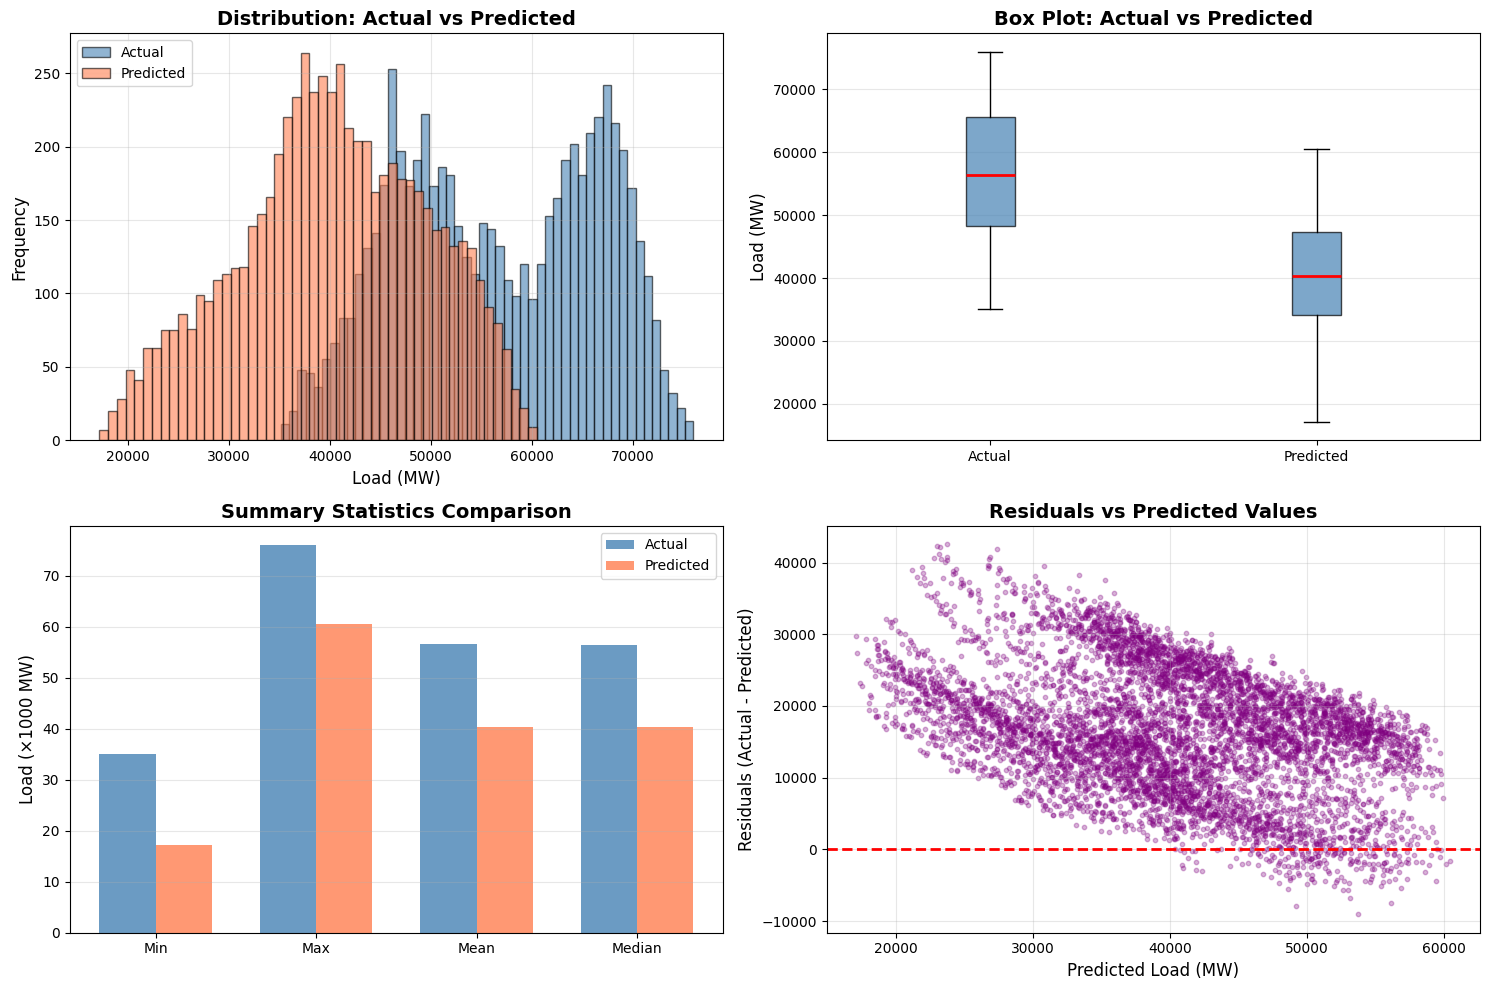

In [45]:
# Load best model weights
try:
    resid_model.load_weights('../../saved_model_outputs/hybrid_outputs/best_residual_model.h5')
    print("Loaded best residual model weights")
except Exception as e:
    print("Using current residual model weights:", str(e))

print("Making residual predictions on test set...")
resid_pred_scaled = resid_model.predict(X_test_seq, verbose=0).flatten()

# Inverse transform residuals back to MW
resid_pred = resid_scaler.inverse_transform(resid_pred_scaled.reshape(-1, 1)).flatten()

# Align timestamps: test index for residual rows is X_test_df.index
# sequences drop first seq_length targets
test_index = X_test_df.index
hybrid_dates = test_index[lookback:lookback + len(resid_pred)]

# SARIMA forecast aligned
sarima_pred_aligned = sarima_forecast.loc[hybrid_dates].values

# Hybrid prediction = SARIMA + predicted residual
y_hybrid_pred = sarima_pred_aligned + resid_pred

# Actual load aligned
y_test_actual = test_series.loc[hybrid_dates].values

print(f"\nPredictions shape: {y_hybrid_pred.shape}")
print(f"Actual values shape: {y_test_actual.shape}")

print(f"\nPrediction summary (HYBRID):")
print(f"  Min predicted: {y_hybrid_pred.min():,.2f} MW")
print(f"  Max predicted: {y_hybrid_pred.max():,.2f} MW")
print(f"  Mean predicted: {y_hybrid_pred.mean():,.2f} MW")

print(f"\nActual summary:")
print(f"  Min actual: {y_test_actual.min():,.2f} MW")
print(f"  Max actual: {y_test_actual.max():,.2f} MW")
print(f"  Mean actual: {y_test_actual.mean():,.2f} MW")

# Visualize prediction vs actual summary
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution comparison
axes[0, 0].hist(y_test_actual, bins=50, alpha=0.6, label='Actual', edgecolor='black', color='steelblue')
axes[0, 0].hist(y_hybrid_pred, bins=50, alpha=0.6, label='Predicted', edgecolor='black', color='coral')
axes[0, 0].set_xlabel('Load (MW)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot comparison
box_data = [y_test_actual, y_hybrid_pred]
axes[0, 1].boxplot(box_data, labels=['Actual', 'Predicted'], patch_artist=True,
                   boxprops=dict(facecolor='steelblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_ylabel('Load (MW)', fontsize=12)
axes[0, 1].set_title('Box Plot: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Summary statistics bar chart
summary_stats = {
    'Min': [y_test_actual.min(), y_hybrid_pred.min()],
    'Max': [y_test_actual.max(), y_hybrid_pred.max()],
    'Mean': [y_test_actual.mean(), y_hybrid_pred.mean()],
    'Median': [np.median(y_test_actual), np.median(y_hybrid_pred)]
}
x = np.arange(len(summary_stats))
width = 0.35
for i, (stat, values) in enumerate(summary_stats.items()):
    axes[1, 0].bar(x[i] - width/2, values[0]/1000, width, label='Actual' if i == 0 else '', 
                   alpha=0.8, color='steelblue')
    axes[1, 0].bar(x[i] + width/2, values[1]/1000, width, label='Predicted' if i == 0 else '', 
                   alpha=0.8, color='coral')
axes[1, 0].set_ylabel('Load (×1000 MW)', fontsize=12)
axes[1, 0].set_title('Summary Statistics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(summary_stats.keys())
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Residual vs predicted
residuals_pred = y_test_actual - y_hybrid_pred
axes[1, 1].scatter(y_hybrid_pred, residuals_pred, alpha=0.3, s=10, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Load (MW)', fontsize=12)
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1, 1].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/hybrid_outputs/05_prediction_summary.png', dpi=300, bbox_inches='tight')
plt.show()


HYBRID MODEL PERFORMANCE METRICS (SARIMA + LSTM-residual)

Mean Absolute Error (MAE): 16,475.40 MW
Root Mean Squared Error (RMSE): 18,460.52 MW
Mean Absolute Percentage Error (MAPE): 28.70%
Mean Error (Bias): -16,351.80 MW
Mean Absolute Scaled Error (MASE): 8.6309
R-squared (R²): -2.5331
Directional Accuracy: 80.97%

Metrics saved to ../../saved_model_outputs/hybrid_outputs/metrics_hybrid.json


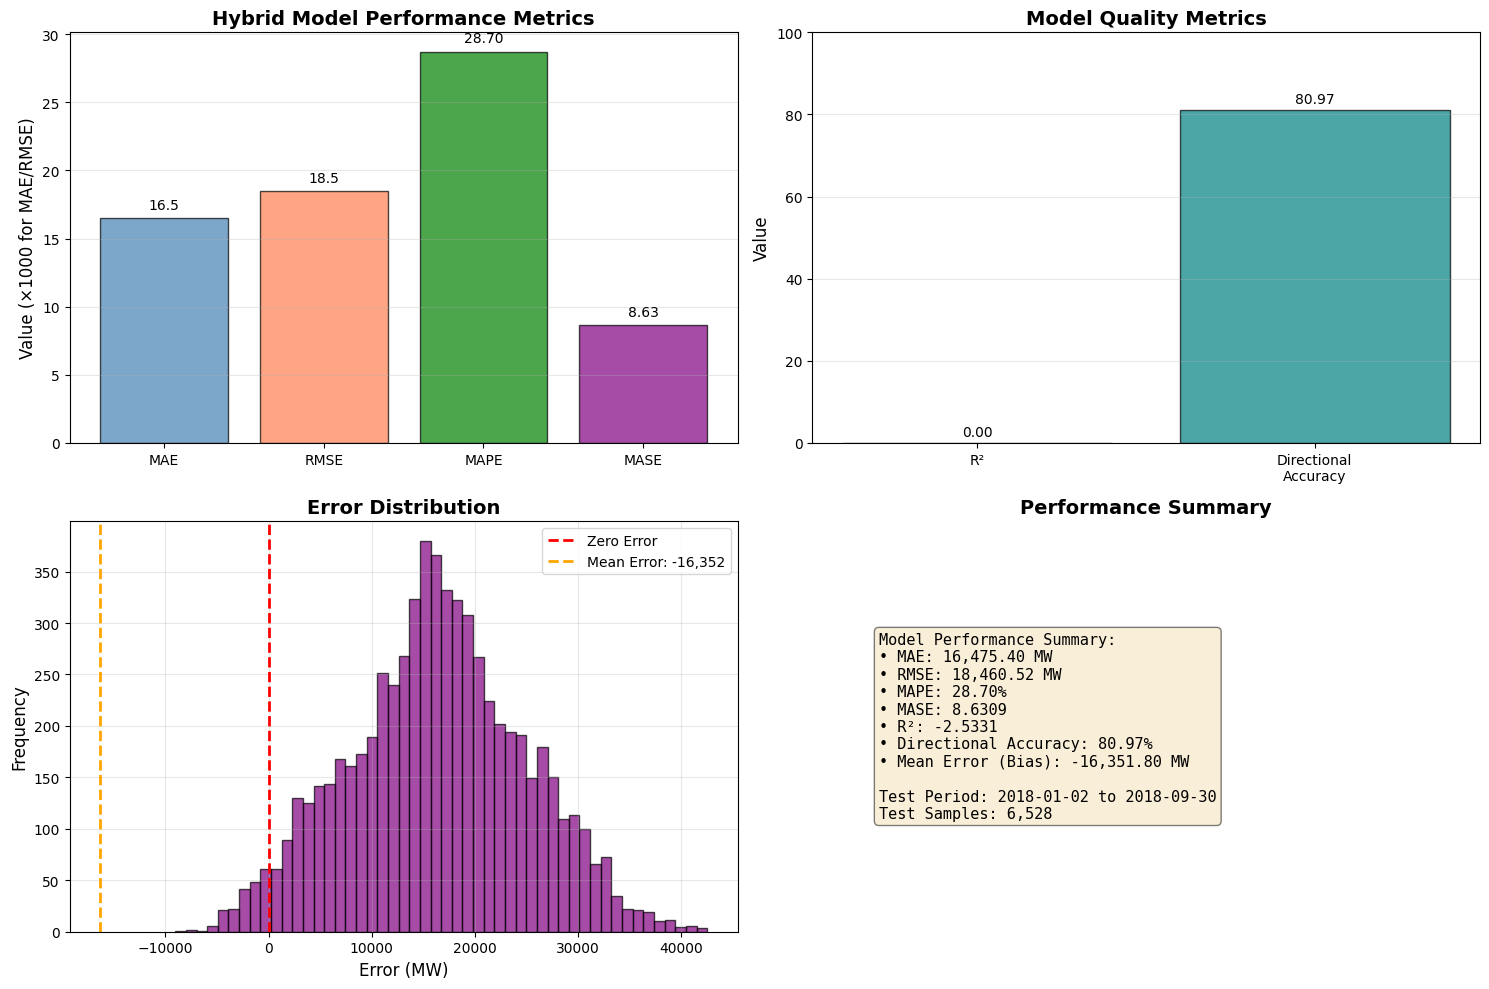

In [46]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(actual, forecast):
    """Calculate comprehensive performance metrics (same as your LSTM notebook)"""
    mask = ~(np.isnan(actual) | np.isnan(forecast))
    actual_clean = actual[mask]
    forecast_clean = forecast[mask]

    mae = np.mean(np.abs(actual_clean - forecast_clean))
    rmse = np.sqrt(np.mean((actual_clean - forecast_clean) ** 2))
    mape = np.mean(np.abs((actual_clean - forecast_clean) / actual_clean)) * 100

    me = np.mean(forecast_clean - actual_clean)

    naive_forecast = np.roll(actual_clean, 1)
    naive_forecast[0] = actual_clean[0]
    naive_error = np.mean(np.abs(actual_clean - naive_forecast))
    mase = mae / naive_error if naive_error > 0 else np.nan

    ss_res = np.sum((actual_clean - forecast_clean) ** 2)
    ss_tot = np.sum((actual_clean - np.mean(actual_clean)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan

    actual_diff = np.diff(actual_clean)
    forecast_diff = np.diff(forecast_clean)
    directional_accuracy = np.mean((actual_diff * forecast_diff) > 0) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'ME': me,
        'MASE': mase,
        'R2': r2,
        'Directional Accuracy': directional_accuracy
    }

metrics_hybrid = calculate_metrics(y_test_actual, y_hybrid_pred)

print("="*80)
print("HYBRID MODEL PERFORMANCE METRICS (SARIMA + LSTM-residual)")
print("="*80)

print(f"\nMean Absolute Error (MAE): {metrics_hybrid['MAE']:,.2f} MW")
print(f"Root Mean Squared Error (RMSE): {metrics_hybrid['RMSE']:,.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {metrics_hybrid['MAPE']:.2f}%")
print(f"Mean Error (Bias): {metrics_hybrid['ME']:,.2f} MW")
print(f"Mean Absolute Scaled Error (MASE): {metrics_hybrid['MASE']:.4f}")
print(f"R-squared (R²): {metrics_hybrid['R2']:.4f}")
print(f"Directional Accuracy: {metrics_hybrid['Directional Accuracy']:.2f}%")

# Save metrics
import json
metrics_dict = {k: float(v) if not np.isnan(v) else None for k, v in metrics_hybrid.items()}
metrics_dict['test_period'] = f"{hybrid_dates.min()} to {hybrid_dates.max()}"
metrics_dict['n_test'] = int(len(y_test_actual))
metrics_dict['seq_length'] = int(lookback)
metrics_dict['sarima_order'] = str(order) if 'order' in globals() else None
metrics_dict['sarima_seasonal_order'] = str(seasonal_order) if 'seasonal_order' in globals() else None

with open('../../saved_model_outputs/hybrid_outputs/metrics_hybrid.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print("\nMetrics saved to ../../saved_model_outputs/hybrid_outputs/metrics_hybrid.json")

# Visualize comprehensive metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metrics bar chart
metric_names = ['MAE', 'RMSE', 'MAPE', 'MASE']
metric_values = [metrics_hybrid['MAE'], metrics_hybrid['RMSE'], 
                 metrics_hybrid['MAPE'], metrics_hybrid['MASE']]
colors = ['steelblue', 'coral', 'green', 'purple']
bars = axes[0, 0].bar(metric_names, [m/1000 if i < 2 else m for i, m in enumerate(metric_values)], 
                      color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Value (×1000 for MAE/RMSE)', fontsize=12)
axes[0, 0].set_title('Hybrid Model Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, metric_values)):
    if i < 2:
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                        f'{val/1000:.1f}', ha='center', va='bottom', fontsize=10)
    else:
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                        f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# R² and Directional Accuracy
quality_metrics = ['R²', 'Directional\nAccuracy']
quality_values = [max(0, metrics_hybrid['R2']), metrics_hybrid['Directional Accuracy']]
bars2 = axes[0, 1].bar(quality_metrics, quality_values, color=['orange', 'teal'], 
                       alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Value', fontsize=12)
axes[0, 1].set_title('Model Quality Metrics', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 100])
axes[0, 1].grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, quality_values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# Error distribution
errors = y_test_actual - y_hybrid_pred
axes[1, 0].hist(errors, bins=50, alpha=0.7, edgecolor='black', color='purple')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].axvline(metrics_hybrid['ME'], color='orange', linestyle='--', linewidth=2, 
                   label=f"Mean Error: {metrics_hybrid['ME']:,.0f}")
axes[1, 0].set_xlabel('Error (MW)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Metrics summary text
summary_text = f"""Model Performance Summary:
• MAE: {metrics_hybrid['MAE']:,.2f} MW
• RMSE: {metrics_hybrid['RMSE']:,.2f} MW
• MAPE: {metrics_hybrid['MAPE']:.2f}%
• MASE: {metrics_hybrid['MASE']:.4f}
• R²: {metrics_hybrid['R2']:.4f}
• Directional Accuracy: {metrics_hybrid['Directional Accuracy']:.2f}%
• Mean Error (Bias): {metrics_hybrid['ME']:,.2f} MW

Test Period: {hybrid_dates.min().strftime('%Y-%m-%d')} to {hybrid_dates.max().strftime('%Y-%m-%d')}
Test Samples: {len(y_test_actual):,}"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].set_title('Performance Summary', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../../saved_model_outputs/hybrid_outputs/06_comprehensive_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


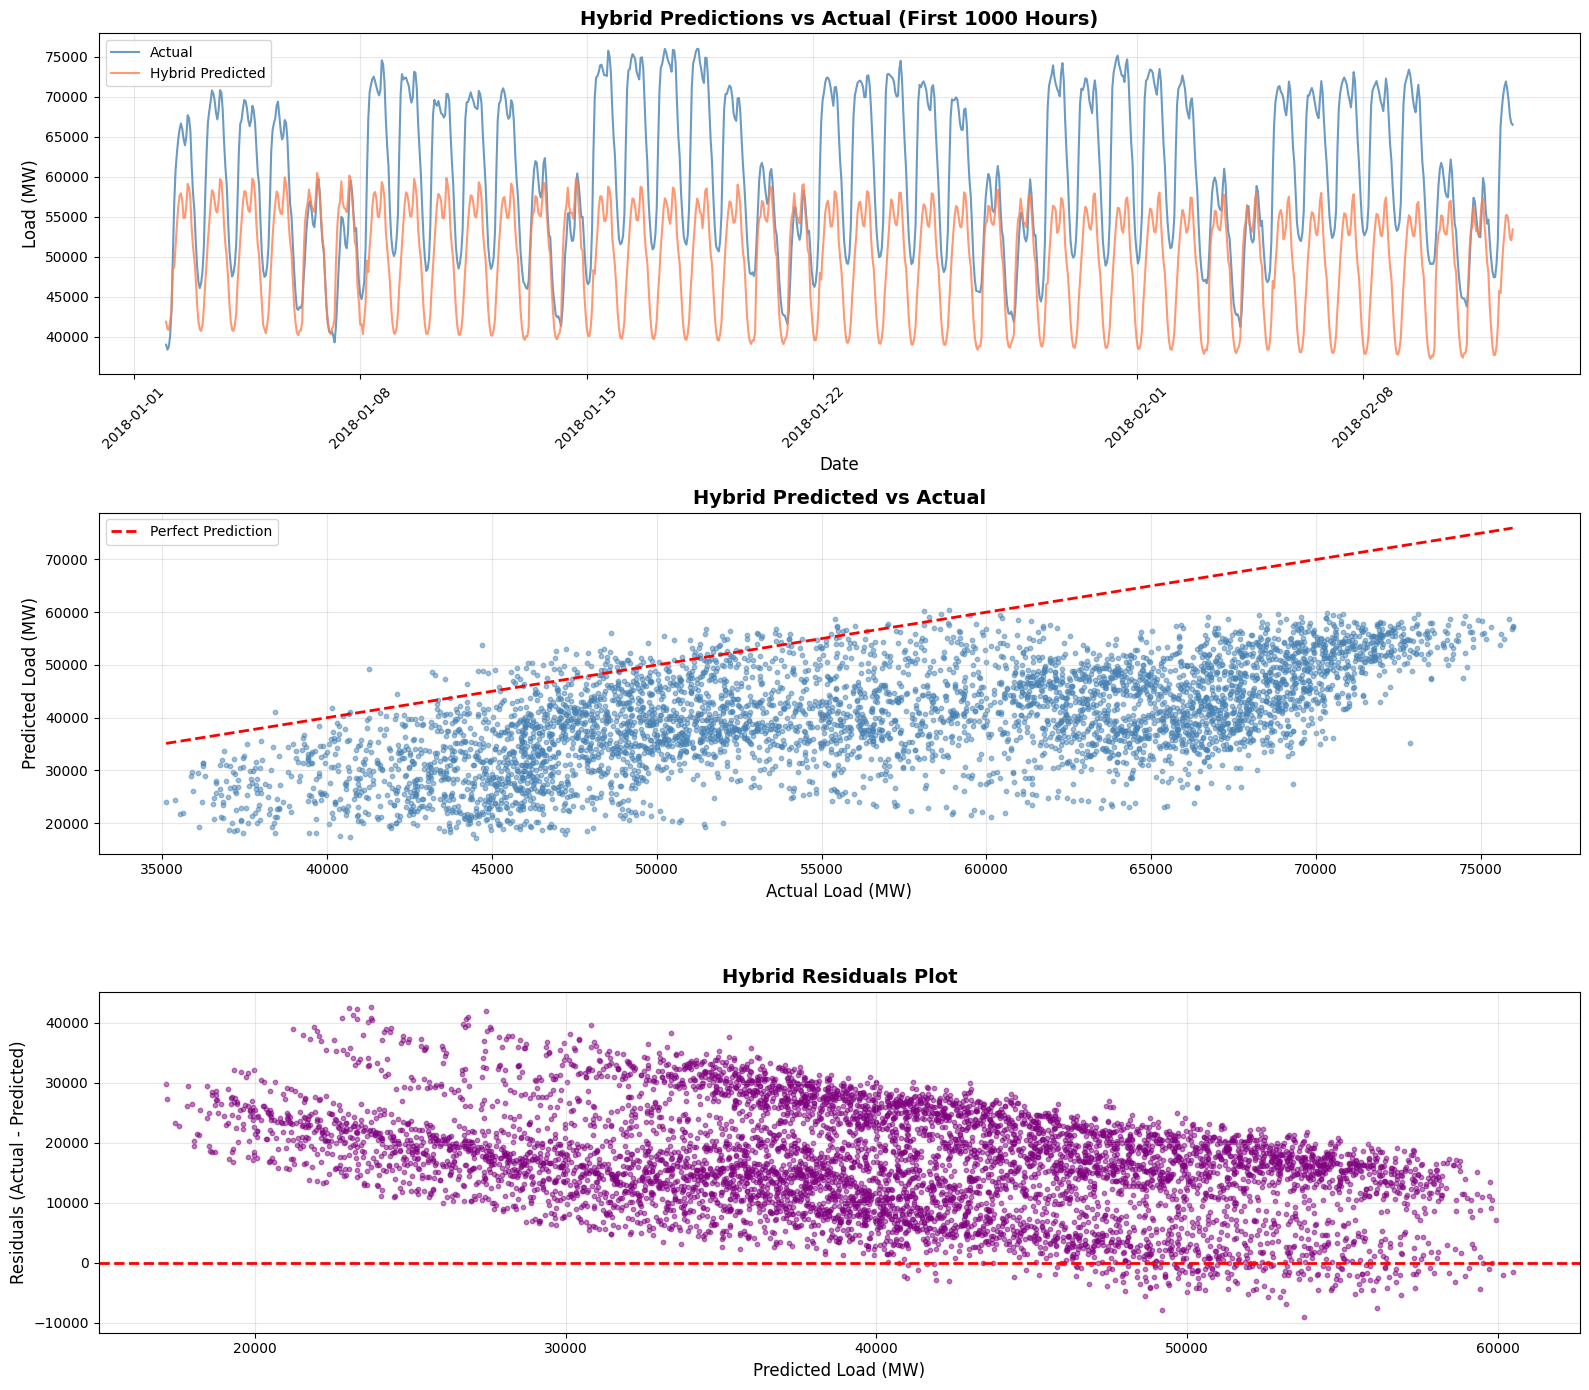

Hybrid visualizations saved to ../../saved_model_outputs/hybrid_outputs/predictions_visualization_hybrid.png


In [47]:
import numpy as np
import matplotlib.pyplot as plt

# test_dates for plotting
test_dates = hybrid_dates

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

plot_length = min(1000, len(y_hybrid_pred))

axes[0].plot(test_dates[:plot_length], y_test_actual[:plot_length],
            label='Actual', linewidth=1.5, alpha=0.8, color='steelblue')
axes[0].plot(test_dates[:plot_length], y_hybrid_pred[:plot_length],
            label='Hybrid Predicted', linewidth=1.5, alpha=0.8, color='coral')
axes[0].set_title('Hybrid Predictions vs Actual (First 1000 Hours)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Load (MW)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

sample_size = min(5000, len(y_hybrid_pred))
sample_idx = np.random.choice(len(y_hybrid_pred), sample_size, replace=False)

axes[1].scatter(y_test_actual[sample_idx], y_hybrid_pred[sample_idx],
               alpha=0.5, s=10, color='steelblue')
axes[1].plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Hybrid Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Load (MW)', fontsize=12)
axes[1].set_ylabel('Predicted Load (MW)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

residuals = y_test_actual - y_hybrid_pred
axes[2].scatter(y_hybrid_pred, residuals, alpha=0.5, s=10, color='purple')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Hybrid Residuals Plot', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Predicted Load (MW)', fontsize=12)
axes[2].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/hybrid_outputs/predictions_visualization_hybrid.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hybrid visualizations saved to ../../saved_model_outputs/hybrid_outputs/predictions_visualization_hybrid.png")


HYBRID PEAK LOAD PERFORMANCE

Peak threshold (90th percentile): 69,295.30 MW
Number of peak hours: 653 (10.0%)

Peak Load Metrics:
  MAE: 19,796.04 MW
  RMSE: 20,382.12 MW

Non-Peak Load Metrics:
  MAE: 16,106.31 MW
  RMSE: 18,234.43 MW

Peak/Non-Peak Error Ratio:
  MAE ratio: 1.23x
  RMSE ratio: 1.12x


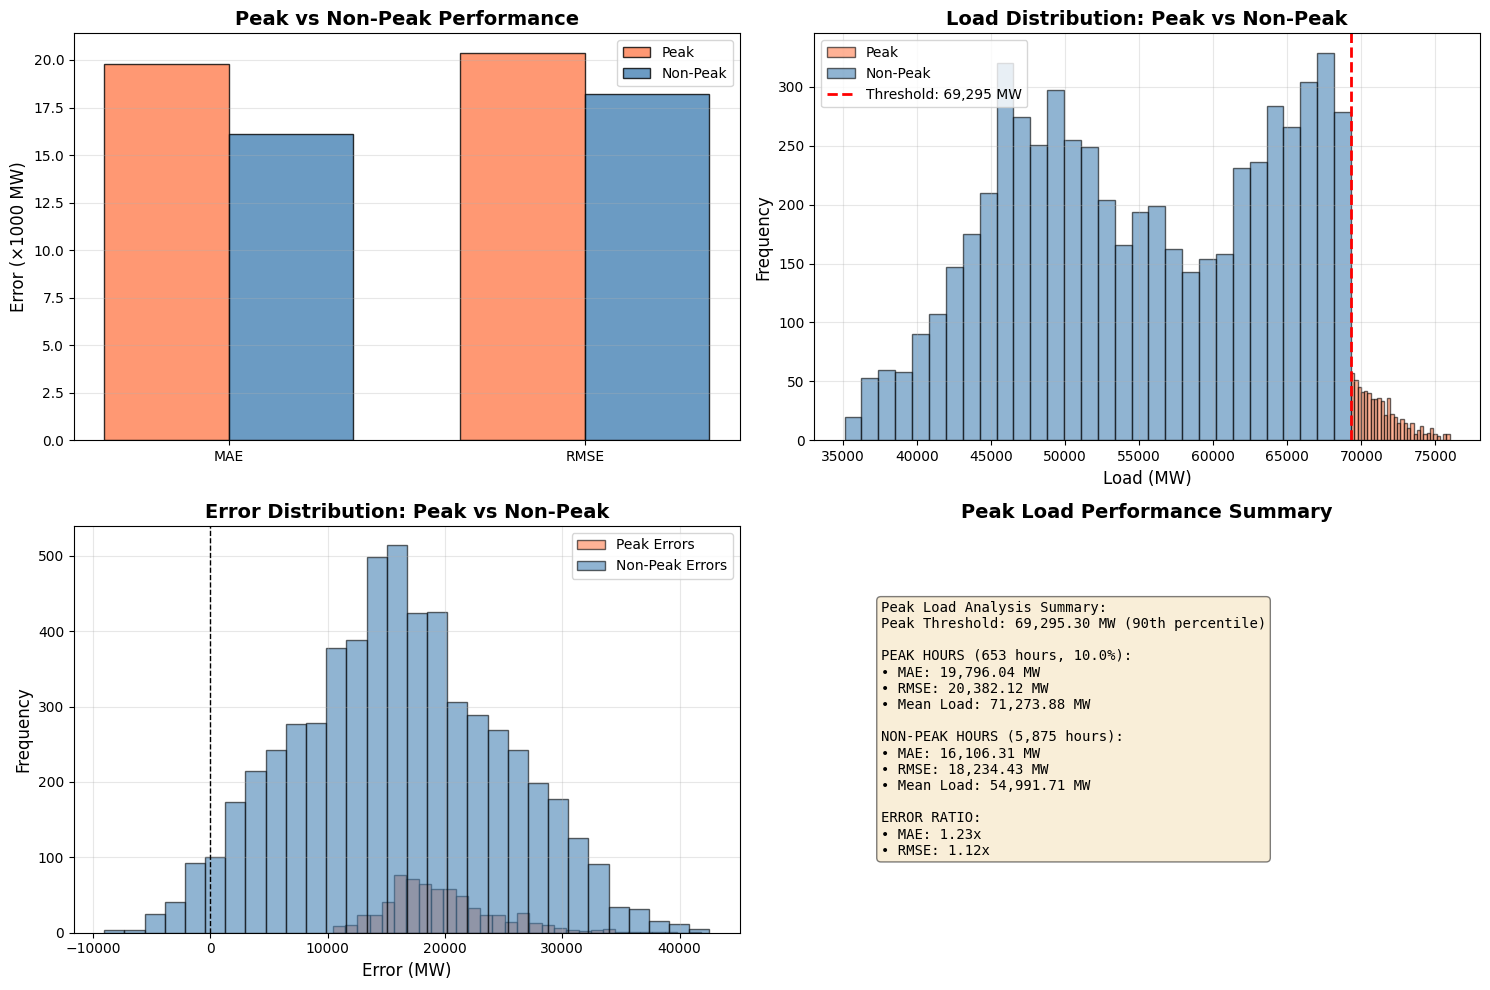

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

peak_threshold = np.percentile(y_test_actual, 90)
is_peak = y_test_actual >= peak_threshold

peak_mae = mean_absolute_error(y_test_actual[is_peak], y_hybrid_pred[is_peak])
peak_rmse = np.sqrt(mean_squared_error(y_test_actual[is_peak], y_hybrid_pred[is_peak]))

non_peak_mae = mean_absolute_error(y_test_actual[~is_peak], y_hybrid_pred[~is_peak])
non_peak_rmse = np.sqrt(mean_squared_error(y_test_actual[~is_peak], y_hybrid_pred[~is_peak]))

print("="*80)
print("HYBRID PEAK LOAD PERFORMANCE")
print("="*80)
print(f"\nPeak threshold (90th percentile): {peak_threshold:,.2f} MW")
print(f"Number of peak hours: {is_peak.sum():,} ({is_peak.sum()/len(is_peak)*100:.1f}%)")

print(f"\nPeak Load Metrics:")
print(f"  MAE: {peak_mae:,.2f} MW")
print(f"  RMSE: {peak_rmse:,.2f} MW")

print(f"\nNon-Peak Load Metrics:")
print(f"  MAE: {non_peak_mae:,.2f} MW")
print(f"  RMSE: {non_peak_rmse:,.2f} MW")

print(f"\nPeak/Non-Peak Error Ratio:")
print(f"  MAE ratio: {peak_mae/non_peak_mae:.2f}x")
print(f"  RMSE ratio: {peak_rmse/non_peak_rmse:.2f}x")

# Visualize peak vs non-peak performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Peak vs non-peak metrics comparison
peak_metrics = ['MAE', 'RMSE']
peak_values = [peak_mae, peak_rmse]
non_peak_values = [non_peak_mae, non_peak_rmse]

x = np.arange(len(peak_metrics))
width = 0.35
axes[0, 0].bar(x - width/2, [v/1000 for v in peak_values], width, label='Peak', 
               alpha=0.8, color='coral', edgecolor='black')
axes[0, 0].bar(x + width/2, [v/1000 for v in non_peak_values], width, label='Non-Peak', 
               alpha=0.8, color='steelblue', edgecolor='black')
axes[0, 0].set_ylabel('Error (×1000 MW)', fontsize=12)
axes[0, 0].set_title('Peak vs Non-Peak Performance', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(peak_metrics)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Peak vs non-peak load distribution
axes[0, 1].hist(y_test_actual[is_peak], bins=30, alpha=0.6, label='Peak', 
                edgecolor='black', color='coral')
axes[0, 1].hist(y_test_actual[~is_peak], bins=30, alpha=0.6, label='Non-Peak', 
                edgecolor='black', color='steelblue')
axes[0, 1].axvline(peak_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold: {peak_threshold:,.0f} MW')
axes[0, 1].set_xlabel('Load (MW)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Load Distribution: Peak vs Non-Peak', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Error distribution by peak/non-peak
peak_errors = y_test_actual[is_peak] - y_hybrid_pred[is_peak]
non_peak_errors = y_test_actual[~is_peak] - y_hybrid_pred[~is_peak]

axes[1, 0].hist(peak_errors, bins=30, alpha=0.6, label='Peak Errors', 
               edgecolor='black', color='coral')
axes[1, 0].hist(non_peak_errors, bins=30, alpha=0.6, label='Non-Peak Errors', 
                edgecolor='black', color='steelblue')
axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Error (MW)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Error Distribution: Peak vs Non-Peak', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics
summary_data = {
    'Peak': {
        'Count': is_peak.sum(),
        'MAE': peak_mae,
        'RMSE': peak_rmse,
        'Mean Load': y_test_actual[is_peak].mean()
    },
    'Non-Peak': {
        'Count': (~is_peak).sum(),
        'MAE': non_peak_mae,
        'RMSE': non_peak_rmse,
        'Mean Load': y_test_actual[~is_peak].mean()
    }
}
summary_text = f"""Peak Load Analysis Summary:
Peak Threshold: {peak_threshold:,.2f} MW (90th percentile)

PEAK HOURS ({is_peak.sum():,} hours, {is_peak.sum()/len(is_peak)*100:.1f}%):
• MAE: {peak_mae:,.2f} MW
• RMSE: {peak_rmse:,.2f} MW
• Mean Load: {y_test_actual[is_peak].mean():,.2f} MW

NON-PEAK HOURS ({(~is_peak).sum():,} hours):
• MAE: {non_peak_mae:,.2f} MW
• RMSE: {non_peak_rmse:,.2f} MW
• Mean Load: {y_test_actual[~is_peak].mean():,.2f} MW

ERROR RATIO:
• MAE: {peak_mae/non_peak_mae:.2f}x
• RMSE: {peak_rmse/non_peak_rmse:.2f}x"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].set_title('Peak Load Performance Summary', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../../saved_model_outputs/hybrid_outputs/07_peak_vs_nonpeak_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [49]:
predictions_df = pd.DataFrame({
    'date': test_dates,
    'actual': y_test_actual,
    'predicted': y_hybrid_pred,
    'sarima_pred': sarima_forecast.loc[test_dates].values,
    'resid_pred': resid_pred,
    'error': y_test_actual - y_hybrid_pred,
    'abs_error': np.abs(y_test_actual - y_hybrid_pred),
    'is_peak': is_peak
})

predictions_df.to_csv('../../saved_model_outputs/hybrid_outputs/hybrid_predictions.csv', index=False)

print("Predictions saved to ../../saved_model_outputs/hybrid_outputs/hybrid_predictions.csv")
print("\nFirst few predictions:")
print(predictions_df.head(10))


Predictions saved to ../../saved_model_outputs/hybrid_outputs/hybrid_predictions.csv

First few predictions:
                       date   actual     predicted   sarima_pred   resid_pred  \
0 2018-01-02 00:00:00+00:00  39033.0  41904.678823  41707.535329   197.143494   
1 2018-01-02 01:00:00+00:00  38421.0  40993.073731  40653.548524   339.525208   
2 2018-01-02 02:00:00+00:00  38771.0  40900.972471  40572.451200   328.521271   
3 2018-01-02 03:00:00+00:00  40156.0  41885.200094  41212.214742   672.985352   
4 2018-01-02 04:00:00+00:00  43366.0  43418.161873  42453.829842   964.332031   
5 2018-01-02 05:00:00+00:00  49805.0  48591.544242  44922.181693  3669.362549   
6 2018-01-02 06:00:00+00:00  56567.0  48654.662305  48655.859632    -1.197327   
7 2018-01-02 07:00:00+00:00  60770.0  51263.971595  51895.422218  -631.450623   
8 2018-01-02 08:00:00+00:00  62933.0  53868.199145  54397.222094  -529.022949   
9 2018-01-02 09:00:00+00:00  64678.0  56234.363875  56287.813506   -53.449631   


eval_df created
Shape: (6528, 3)
                            actual        sarima        hybrid
utc_timestamp                                                 
2018-01-02 00:00:00+00:00  39033.0  41707.535329  41904.678823
2018-01-02 01:00:00+00:00  38421.0  40653.548524  40993.073731
2018-01-02 02:00:00+00:00  38771.0  40572.451200  40900.972471
2018-01-02 03:00:00+00:00  40156.0  41212.214742  41885.200094
2018-01-02 04:00:00+00:00  43366.0  42453.829842  43418.161873
CRITICAL PEAK PERFORMANCE (Hour=10 AND Actual >= p90)
p90 threshold: 69295.3
Critical peak samples: 91

SARIMA Critical Peaks
  MAE : 20388.49286196972
  RMSE: 21028.847115543784

HYBRID Critical Peaks
  MAE : 20393.43548441647
  RMSE: 21035.530762589085

STABILITY Critical Peaks
  SARIMA error var: 26816456.157727703
  HYBRID error var: 26896914.0912947
  SARIMA error std: 5178.460790401691
  HYBRID error std: 5186.22349029568


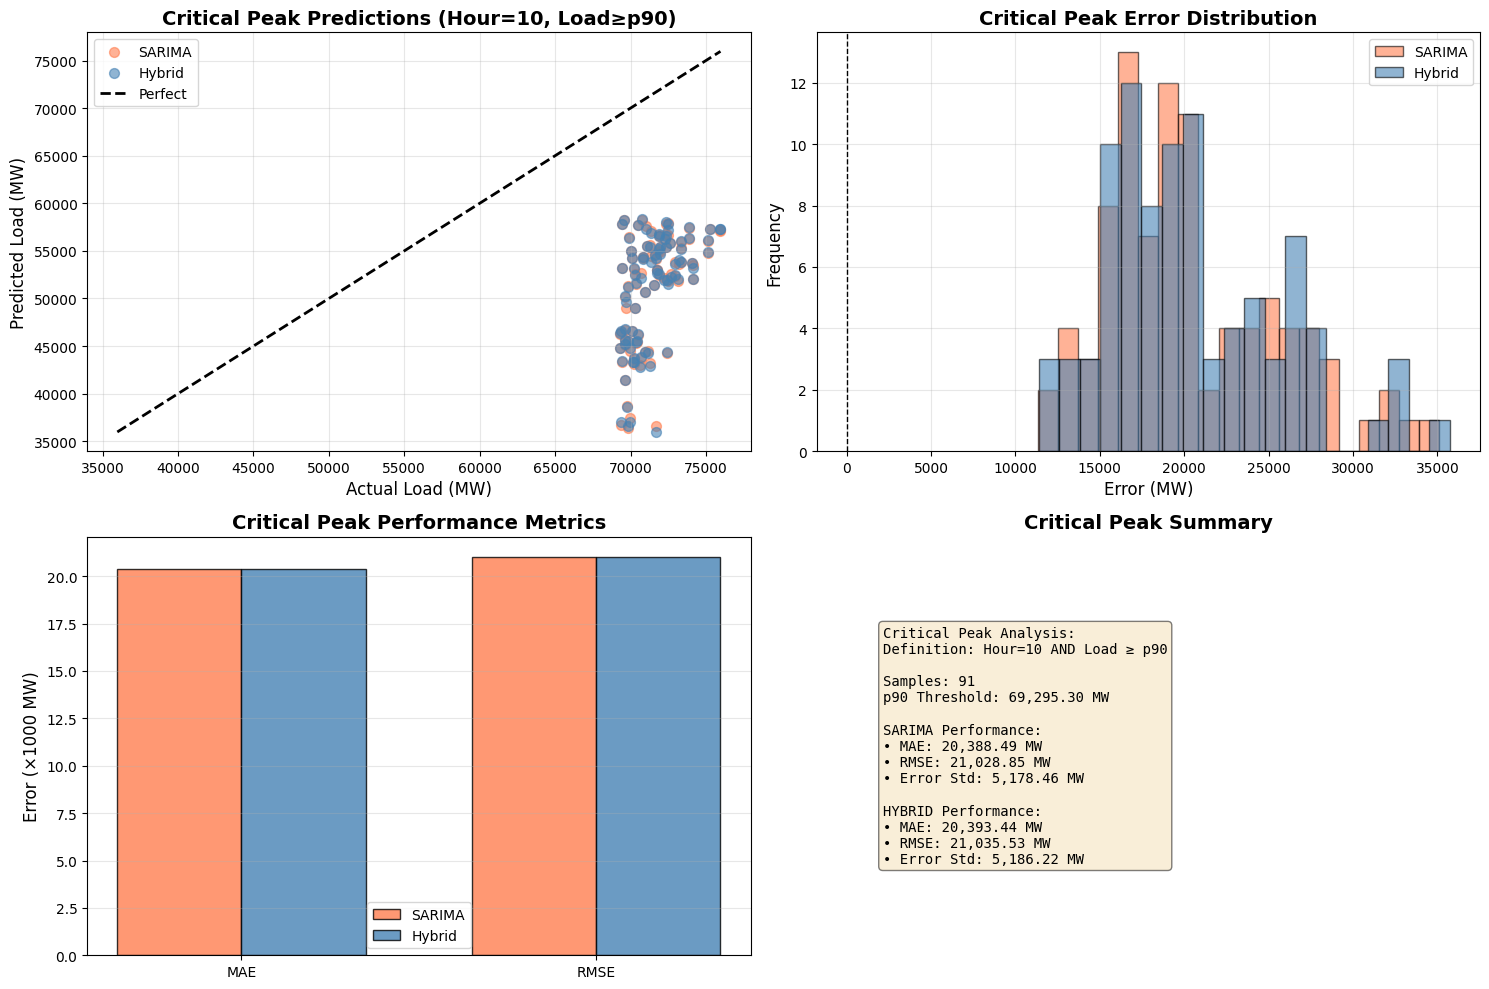

In [50]:
# Magnitude peak (top 10% load)
eval_df = pd.DataFrame(
    {
        "actual": y_test_actual,
        "sarima": sarima_forecast.loc[hybrid_dates].values,
        "hybrid": y_hybrid_pred,
    },
    index=hybrid_dates
)

print("eval_df created")
print("Shape:", eval_df.shape)
print(eval_df.head())


p90 = eval_df["actual"].quantile(0.90)
is_p90 = eval_df["actual"] >= p90

peak_hour = 10  # EDA finding: peak hour is 10 AM
is_hour10 = eval_df.index.hour == peak_hour

# Critical peaks: hour 10 and p90 magnitude
is_critical = is_hour10 & is_p90
critical_df = eval_df.loc[is_critical]

print("="*80)
print("CRITICAL PEAK PERFORMANCE (Hour=10 AND Actual >= p90)")
print("="*80)
print("p90 threshold:", float(p90))
print("Critical peak samples:", len(critical_df))

if len(critical_df) > 0:
    print("\nSARIMA Critical Peaks")
    print("  MAE :", mean_absolute_error(critical_df["actual"], critical_df["sarima"]))
    print("  RMSE:", rmse(critical_df["actual"], critical_df["sarima"]))

    print("\nHYBRID Critical Peaks")
    print("  MAE :", mean_absolute_error(critical_df["actual"], critical_df["hybrid"]))
    print("  RMSE:", rmse(critical_df["actual"], critical_df["hybrid"]))

    sarima_err_c = critical_df["actual"] - critical_df["sarima"]
    hybrid_err_c = critical_df["actual"] - critical_df["hybrid"]

    print("\nSTABILITY Critical Peaks")
    print("  SARIMA error var:", float(sarima_err_c.var()))
    print("  HYBRID error var:", float(hybrid_err_c.var()))
    print("  SARIMA error std:", float(sarima_err_c.std()))
    print("  HYBRID error std:", float(hybrid_err_c.std()))
    
    # Visualize critical peak performance
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Critical peak predictions vs actual
    axes[0, 0].scatter(critical_df["actual"], critical_df["sarima"], 
                       alpha=0.6, label='SARIMA', s=50, color='coral')
    axes[0, 0].scatter(critical_df["actual"], critical_df["hybrid"], 
                       alpha=0.6, label='Hybrid', s=50, color='steelblue')
    min_val = min(critical_df["actual"].min(), critical_df["sarima"].min(), critical_df["hybrid"].min())
    max_val = max(critical_df["actual"].max(), critical_df["sarima"].max(), critical_df["hybrid"].max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')
    axes[0, 0].set_xlabel('Actual Load (MW)', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Load (MW)', fontsize=12)
    axes[0, 0].set_title('Critical Peak Predictions (Hour=10, Load≥p90)', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Critical peak errors
    axes[0, 1].hist(sarima_err_c, bins=20, alpha=0.6, label='SARIMA', 
                    edgecolor='black', color='coral')
    axes[0, 1].hist(hybrid_err_c, bins=20, alpha=0.6, label='Hybrid', 
                     edgecolor='black', color='steelblue')
    axes[0, 1].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].set_xlabel('Error (MW)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Critical Peak Error Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Metrics comparison
    crit_metrics = ['MAE', 'RMSE']
    crit_sarima = [mean_absolute_error(critical_df["actual"], critical_df["sarima"]),
                   rmse(critical_df["actual"], critical_df["sarima"])]
    crit_hybrid = [mean_absolute_error(critical_df["actual"], critical_df["hybrid"]),
                  rmse(critical_df["actual"], critical_df["hybrid"])]
    
    x = np.arange(len(crit_metrics))
    width = 0.35
    axes[1, 0].bar(x - width/2, [m/1000 for m in crit_sarima], width, label='SARIMA', 
                   alpha=0.8, color='coral', edgecolor='black')
    axes[1, 0].bar(x + width/2, [m/1000 for m in crit_hybrid], width, label='Hybrid', 
                   alpha=0.8, color='steelblue', edgecolor='black')
    axes[1, 0].set_ylabel('Error (×1000 MW)', fontsize=12)
    axes[1, 0].set_title('Critical Peak Performance Metrics', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(crit_metrics)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Summary
    summary_text = f"""Critical Peak Analysis:
Definition: Hour=10 AND Load ≥ p90

Samples: {len(critical_df):,}
p90 Threshold: {p90:,.2f} MW

SARIMA Performance:
• MAE: {crit_sarima[0]:,.2f} MW
• RMSE: {crit_sarima[1]:,.2f} MW
• Error Std: {sarima_err_c.std():,.2f} MW

HYBRID Performance:
• MAE: {crit_hybrid[0]:,.2f} MW
• RMSE: {crit_hybrid[1]:,.2f} MW
• Error Std: {hybrid_err_c.std():,.2f} MW"""
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                    family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 1].set_title('Critical Peak Summary', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('../../saved_model_outputs/hybrid_outputs/08_critical_peak_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No critical peak samples found in this evaluation window.")


In [51]:
!pip install "numpy<2.3"

## Explainability

In [52]:
# If needed (in a notebook cell):
!pip install shap

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [53]:
# --- Align sequence targets to timestamps ---
# X_test_df.index is the per-timestep index for test residual features (after dropna etc.)
test_index = X_test_df.index

# timestamps corresponding to each y in X_test_seq
seq_target_times = test_index[lookback: lookback + len(X_test_seq)]
assert len(seq_target_times) == len(X_test_seq)

# Build metadata from eval_df (actual/sarima/hybrid)
meta = eval_df.loc[seq_target_times].copy()

# Add error columns
meta["err_hybrid"] = meta["actual"] - meta["hybrid"]
meta["abs_err_hybrid"] = meta["err_hybrid"].abs()

meta["err_sarima"] = meta["actual"] - meta["sarima"]
meta["abs_err_sarima"] = meta["err_sarima"].abs()

# Add calendar slices
meta["is_weekend"] = meta.index.dayofweek >= 5  # Sat/Sun

print(meta.shape)
meta.head()


(6528, 8)


,actual,sarima,hybrid,err_hybrid,abs_err_hybrid,err_sarima,abs_err_sarima,is_weekend
utc_timestamp,,,,,,,,
2018-01-02 00:00:00+00:00,39033.0,41707.535329,41904.678823,-2871.678823,2871.678823,-2674.535329,2674.535329,False
2018-01-02 01:00:00+00:00,38421.0,40653.548524,40993.073731,-2572.073731,2572.073731,-2232.548524,2232.548524,False
2018-01-02 02:00:00+00:00,38771.0,40572.451200,40900.972471,-2129.972471,2129.972471,-1801.451200,1801.451200,False
2018-01-02 03:00:00+00:00,40156.0,41212.214742,41885.200094,-1729.200094,1729.200094,-1056.214742,1056.214742,False
2018-01-02 04:00:00+00:00,43366.0,42453.829842,43418.161873,-52.161873,52.161873,912.170158,912.170158,False


In [54]:
# Magnitude peak (top 10% by actual load)
p90 = meta["actual"].quantile(0.90)
meta["is_peak"] = meta["actual"] >= p90

# Optional: EDA peak hour slice (10:00)
meta["is_peak_hour10"] = meta.index.hour == 10


In [55]:
# Pull temperature proxy at the sequence target time
if "temp_proxy" in X_test_df.columns:
    meta["temp_proxy"] = X_test_df.loc[seq_target_times, "temp_proxy"].values
else:
    raise ValueError("temp_proxy not found in X_test_df. Use another weather feature.")

# Define extremes: heat waves (top 5%) and mild (middle band)
t95 = meta["temp_proxy"].quantile(0.95)
t50 = meta["temp_proxy"].quantile(0.50)

meta["is_extreme_heat"] = meta["temp_proxy"] >= t95
# Mild = between 40th and 60th percentile (stable baseline)
t40 = meta["temp_proxy"].quantile(0.40)
t60 = meta["temp_proxy"].quantile(0.60)
meta["is_mild"] = meta["temp_proxy"].between(t40, t60)


In [56]:
# Define mispredicted = top 10% absolute error, accurate = bottom 10%
e90 = meta["abs_err_hybrid"].quantile(0.90)
e10 = meta["abs_err_hybrid"].quantile(0.10)

meta["is_mispred"] = meta["abs_err_hybrid"] >= e90
meta["is_accurate"] = meta["abs_err_hybrid"] <= e10

print("Mispred count:", meta["is_mispred"].sum())
print("Accurate count:", meta["is_accurate"].sum())


Mispred count: 653
Accurate count: 653


In [57]:
# Choose background and evaluation samples
rng = np.random.default_rng(42)

N_bg = min(100, len(X_test_seq))
N_explain = min(500, len(X_test_seq))  # increase if your machine supports it

bg_idx = rng.choice(len(X_test_seq), size=N_bg, replace=False)
explain_idx = rng.choice(len(X_test_seq), size=N_explain, replace=False)

X_bg = X_test_seq[bg_idx]
X_explain = X_test_seq[explain_idx]

# Build explainer
explainer = shap.GradientExplainer(resid_model, X_bg)

# Compute SHAP values: returns array shaped like X_explain (N, seq_length, n_features)
shap_values = explainer.shap_values(X_explain)

# shap_values may come as a list for multi-output models; your model outputs 1 value
if isinstance(shap_values, list):
    shap_values = shap_values[0]

print("SHAP values shape:", shap_values.shape)


SHAP values shape: (500, 24, 83, 1)


In [58]:
# Feature names in the same order as X_test_df columns used in training
# In your hybrid code, you used: X_train_df.values, so columns are X_train_df.columns
feature_names = list(X_test_df.columns)  # includes sarima_pred, sarima_pred_diff1 if added

# Aggregate over time dimension
# result: (N_explain, n_features)
shap_feat = np.mean(np.abs(shap_values), axis=1)   # (N, F, 1)

# 2) Remove the last singleton dimension
shap_feat = np.squeeze(shap_feat, axis=-1)         # (N, F)

# Sanity check
print("shap_feat shape:", shap_feat.shape)         # should be (500, 95)

# Now build DataFrame
shap_feat_df = pd.DataFrame(shap_feat, columns=feature_names)

# Map explained samples to timestamps
explain_times = seq_target_times[explain_idx]
shap_feat_df["time"] = explain_times
shap_feat_df = shap_feat_df.set_index("time")

print(shap_feat_df.shape)
shap_feat_df.head()


shap_feat shape: (500, 83)
(500, 83)


,DE_50hertz_load_actual_entsoe_transparency,DE_amprion_load_actual_entsoe_transparency,DE_tennet_load_actual_entsoe_transparency,DE_transnetbw_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_50hertz_solar_generation_actual,DE_LU_solar_generation_actual,DE_amprion_solar_generation_actual,DE_tennet_solar_generation_actual,DE_transnetbw_solar_generation_actual,...,wind_proxy,temp_proxy,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,season_Spring,season_Summer,season_Winter,control_regions_complete,sarima_pred
time,,,,,,,,,,,,,,,,,,,,,
2018-05-18 05:00:00+00:00,0.011774,0.014334,0.003753,0.007571,0.004103,0.010026,0.0,0.002043,0.001945,0.001473,...,0.001757,0.001579,0.001325,0.000592,0.001567,0.003257,0.004031,0.000900,0.002094,0.008446
2018-05-11 16:00:00+00:00,0.013227,0.013139,0.004027,0.015741,0.010696,0.010845,0.0,0.007103,0.004517,0.005447,...,0.013499,0.004813,0.001728,0.002638,0.001217,0.011230,0.014501,0.000940,0.002943,0.013823
2018-05-26 12:00:00+00:00,0.036778,0.008982,0.003339,0.022650,0.018241,0.045343,0.0,0.008464,0.007328,0.004544,...,0.012246,0.005641,0.001326,0.002728,0.001642,0.012306,0.010274,0.002640,0.003769,0.013761
2018-01-23 08:00:00+00:00,0.041140,0.045991,0.004941,0.021875,0.010012,0.023276,0.0,0.005115,0.004498,0.004769,...,0.006052,0.002604,0.001470,0.002133,0.002873,0.006360,0.006789,0.009372,0.003869,0.016068
2018-02-16 23:00:00+00:00,0.013594,0.006963,0.001600,0.003490,0.005820,0.013445,0.0,0.003217,0.003275,0.001178,...,0.001434,0.001855,0.003147,0.000589,0.001751,0.002369,0.005615,0.001910,0.001842,0.014550


In [59]:
# Align meta to only the SHAP-explained timestamps
meta_shap = meta.loc[shap_feat_df.index].copy()

print("meta original:", meta.shape)
print("shap_feat_df:", shap_feat_df.shape)
print("meta_shap:", meta_shap.shape)


meta original: (6528, 15)
shap_feat_df: (500, 83)
meta_shap: (500, 15)


In [60]:
# Peak vs non-peak on the SHAP subset
p90_shap = meta_shap["actual"].quantile(0.90)
meta_shap["is_peak"] = meta_shap["actual"] >= p90_shap

# Weekday vs weekend
meta_shap["is_weekend"] = meta_shap.index.dayofweek >= 5

# Peak hour 10 (optional)
meta_shap["is_hour10"] = meta_shap.index.hour == 10


In [61]:
def compare_groups(shap_df, meta_df, mask_a, mask_b, title_a, title_b, top_n=15):
    idx_a = meta_df.index[mask_a]
    idx_b = meta_df.index[mask_b]

    A = shap_df.reindex(idx_a).dropna(how="any")
    B = shap_df.reindex(idx_b).dropna(how="any")

    if len(A) == 0 or len(B) == 0:
        raise ValueError(f"Empty group: {title_a} has {len(A)} samples, {title_b} has {len(B)} samples.")

    mean_A = A.mean(axis=0)
    mean_B = B.mean(axis=0)

    top_feats = (mean_A + mean_B).sort_values(ascending=False).head(top_n).index

    comp = pd.DataFrame({
        title_a: mean_A[top_feats],
        title_b: mean_B[top_feats],
        "diff(A-B)": (mean_A - mean_B)[top_feats]
    }).sort_values("diff(A-B)", ascending=False)

    display(comp)

    plt.figure(figsize=(10, 6))
    plt.barh(comp.index[::-1], comp[title_a].values[::-1], alpha=0.7, label=title_a)
    plt.barh(comp.index[::-1], comp[title_b].values[::-1], alpha=0.7, label=title_b)
    plt.title(f"Mean |SHAP| (Residual LSTM): {title_a} vs {title_b}")
    plt.xlabel("Mean |SHAP|")
    plt.legend()
    plt.tight_layout()
    # Save plot with sanitized filename
    filename = f"../../saved_model_outputs/hybrid_outputs/shap_comparison_{title_a.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('%', '')}_vs_{title_b.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('%', '')}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

    return comp


,Peak (p90+),Non-peak,diff(A-B)
DE_amprion_load_actual_entsoe_transparency,0.095641,0.044231,0.051410
target_load_lag_24,0.053075,0.034121,0.018954
target_load_rolling_mean_3,0.037842,0.021311,0.016530
DE_transnetbw_load_actual_entsoe_transparency,0.035127,0.021030,0.014097
sarima_pred,0.028298,0.014840,0.013458
DE_50hertz_load_actual_entsoe_transparency,0.058242,0.045022,0.013220
target_load_ema_6,0.033790,0.021489,0.012301
DE_wind_onshore_generation_actual,0.018964,0.007179,0.011784
wind_proxy,0.020549,0.008788,0.011762
DE_50hertz_wind_generation_actual,0.018346,0.009235,0.009111


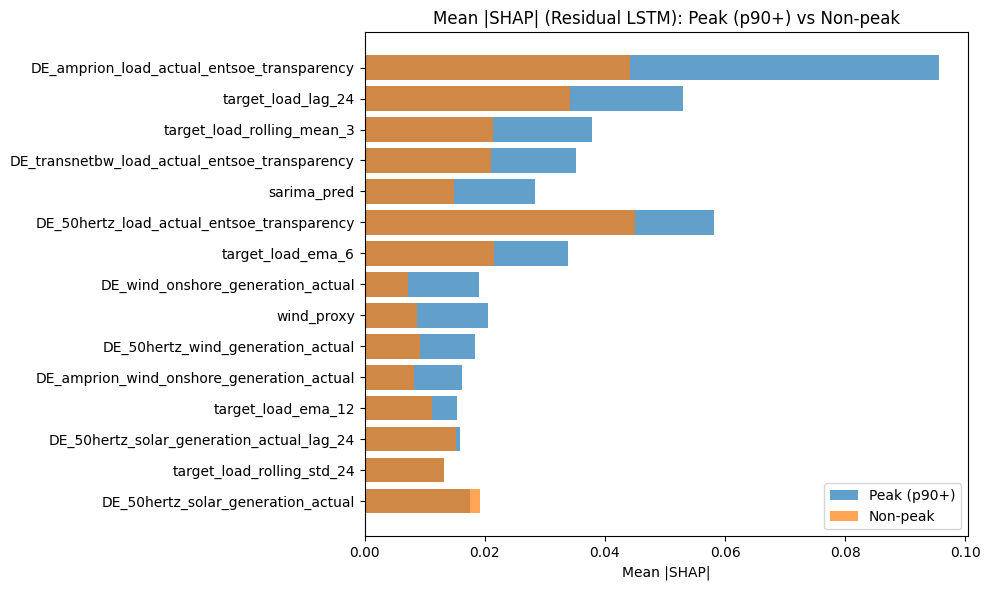

In [62]:
comp_peak = compare_groups(
    shap_feat_df, meta_shap,
    mask_a=meta_shap["is_peak"].values,
    mask_b=(~meta_shap["is_peak"]).values,
    title_a="Peak (p90+)",
    title_b="Non-peak",
    top_n=15
)


,Weekday,Weekend,diff(A-B)
DE_amprion_load_actual_entsoe_transparency,0.052174,0.042578,0.009596
target_load_lag_24,0.038682,0.029551,0.009131
DE_50hertz_load_actual_entsoe_transparency,0.047720,0.043007,0.004714
season_Summer,0.010968,0.008568,0.002401
target_load_rolling_mean_3,0.023556,0.021531,0.002025
DE_50hertz_wind_generation_actual,0.010709,0.008781,0.001928
sarima_pred,0.016390,0.015691,0.000699
DE_50hertz_solar_generation_actual_lag_24,0.015111,0.015520,-0.000409
DE_transnetbw_load_actual_entsoe_transparency,0.022178,0.023075,-0.000897
target_load_ema_6,0.022317,0.023694,-0.001377


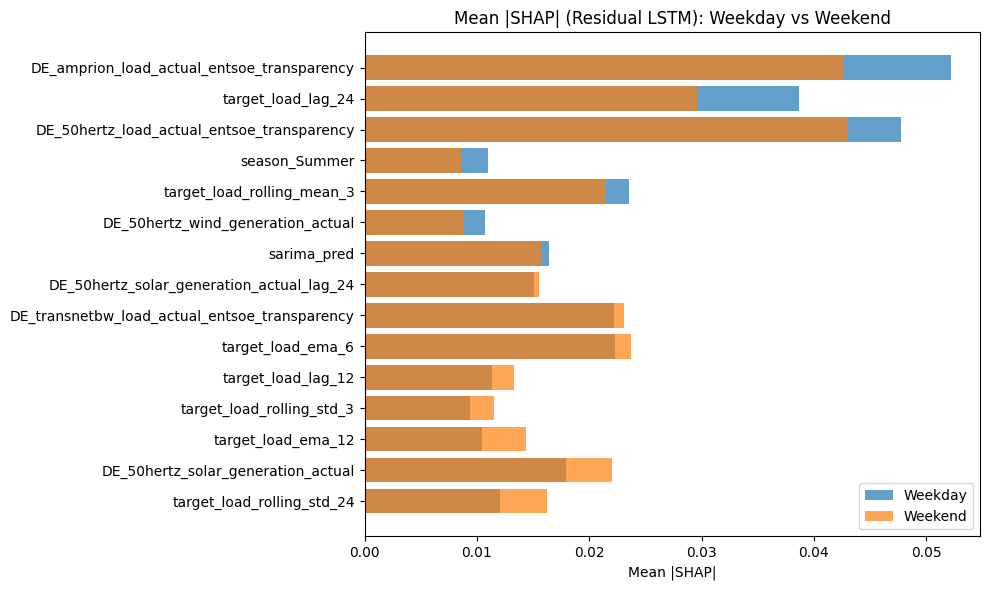

In [63]:
comp_weekend = compare_groups(
    shap_feat_df, meta_shap,
    mask_a=(~meta_shap["is_weekend"]).values,
    mask_b=meta_shap["is_weekend"].values,
    title_a="Weekday",
    title_b="Weekend",
    top_n=15
)


,Extreme heat (top 5%),Mild (40–60%),diff(A-B)
DE_50hertz_solar_generation_actual,0.034239,0.015764,0.018475
DE_50hertz_load_actual_entsoe_transparency,0.062760,0.046151,0.016609
DE_50hertz_solar_generation_actual_lag_24,0.023512,0.012788,0.010723
target_load_lag_24,0.043802,0.038639,0.005162
DE_transnetbw_load_actual_entsoe_transparency,0.027785,0.023342,0.004442
season_Summer,0.014124,0.009826,0.004298
target_load_lag_48,0.013688,0.009936,0.003753
DE_amprion_load_actual_entsoe_transparency,0.057084,0.054734,0.002350
target_load_rolling_mean_3,0.025295,0.025255,0.000040
target_load_lag_12,0.009363,0.011484,-0.002121


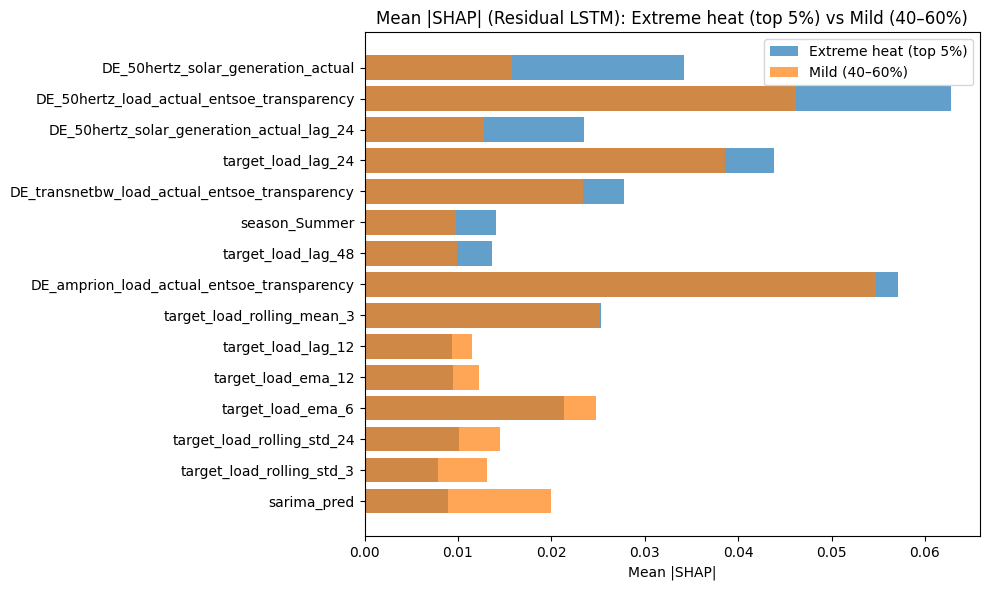

In [64]:
comp_weather = compare_groups(
    shap_feat_df, meta_shap,
    mask_a=meta_shap["is_extreme_heat"].values,
    mask_b=meta_shap["is_mild"].values,
    title_a="Extreme heat (top 5%)",
    title_b="Mild (40–60%)",
    top_n=15
)


,Mispredicted (top 10% error),Accurate (bottom 10% error),diff(A-B)
target_load_lag_24,0.025553,0.026651,-0.001098
target_load_rolling_std_3,0.010518,0.011803,-0.001285
target_load_lag_48,0.008361,0.012008,-0.003647
target_load_rolling_mean_3,0.015567,0.022529,-0.006961
DE_amprion_load_actual_entsoe_transparency,0.031493,0.038521,-0.007029
DE_50hertz_solar_generation_actual_lag_24,0.010797,0.017881,-0.007084
target_load_rolling_std_24,0.009825,0.018417,-0.008592
target_load_lag_12,0.005987,0.016516,-0.010529
day_of_week,0.004622,0.015695,-0.011073
target_load_ema_12,0.004826,0.016044,-0.011218


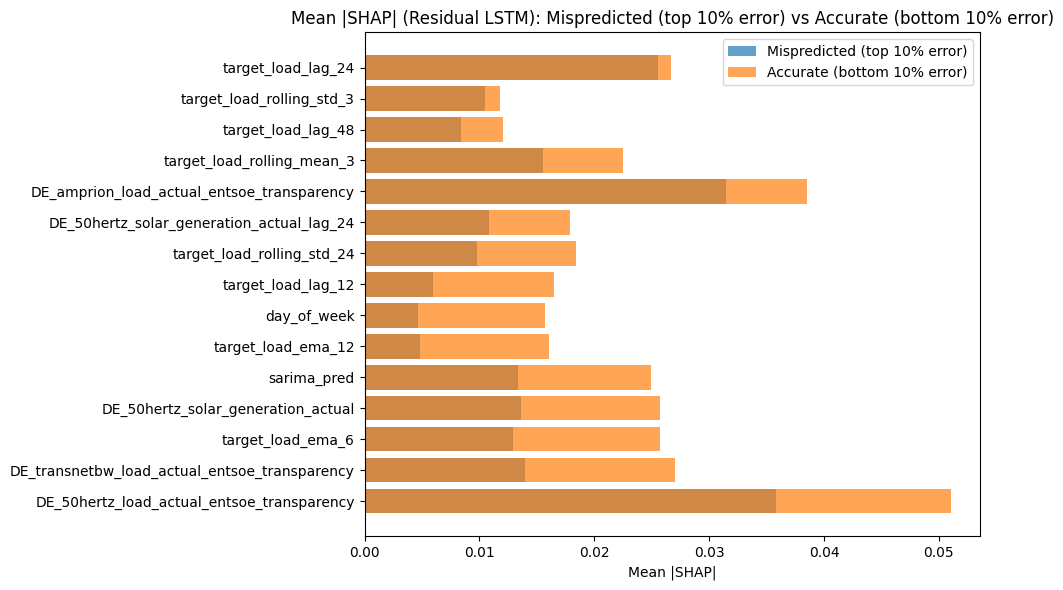

In [65]:
comp_error = compare_groups(
    shap_feat_df, meta_shap,
    mask_a=meta_shap["is_mispred"].values,
    mask_b=meta_shap["is_accurate"].values,
    title_a="Mispredicted (top 10% error)",
    title_b="Accurate (bottom 10% error)",
    top_n=15
)


Above, We applied SHAP (GradientExplainer) to the residual LSTM component of the SARIMA+LSTM hybrid. SHAP values were aggregated across the lookback window to obtain per-feature contributions, and compared across operational regimes (peak/non-peak, weekday/weekend, extreme weather/mild, mispredicted/accurate) to identify regime-specific drivers of model corrections.

In [66]:
# shap_values: (N, T, F, 1)
sv = np.squeeze(shap_values, axis=-1)         # (N, T, F)

# mean absolute shap per feature (aggregate over time)
shap_feat = np.mean(np.abs(sv), axis=1)       # (N, F)

shap_feat_df = pd.DataFrame(shap_feat, columns=feature_names, index=explain_times)
meta_shap = meta.loc[shap_feat_df.index].copy()


In [67]:
p90 = meta_shap["actual"].quantile(0.90)
meta_shap["is_peak"] = meta_shap["actual"] >= p90
meta_shap["is_weekend"] = meta_shap.index.dayofweek >= 5
t95 = meta_shap["temp_proxy"].quantile(0.95)
t40 = meta_shap["temp_proxy"].quantile(0.40)
t60 = meta_shap["temp_proxy"].quantile(0.60)

meta_shap["is_extreme_heat"] = meta_shap["temp_proxy"] >= t95
meta_shap["is_mild"] = meta_shap["temp_proxy"].between(t40, t60)
e90 = meta_shap["abs_err_hybrid"].quantile(0.90)
e10 = meta_shap["abs_err_hybrid"].quantile(0.10)

meta_shap["is_mispred"] = meta_shap["abs_err_hybrid"] >= e90
meta_shap["is_accurate"] = meta_shap["abs_err_hybrid"] <= e10


In [68]:
comp_peak.to_csv("../../saved_model_outputs/hybrid_outputs/shap_peak_vs_nonpeak.csv")
comp_weekend.to_csv("../../saved_model_outputs/hybrid_outputs/shap_weekday_vs_weekend.csv")
comp_weather.to_csv("../../saved_model_outputs/hybrid_outputs/shap_extremeheat_vs_mild.csv")
comp_error.to_csv("../../saved_model_outputs/hybrid_outputs/shap_mispred_vs_accurate.csv")


We apply SHAP to the residual-LSTM component of the SARIMA+LSTM hybrid model to explain the learned correction added to the SARIMA baseline. For each prediction timestamp, SHAP values quantify the contribution of engineered features over the prior 24-hour lookback window toward the residual correction output. We aggregate absolute SHAP values across time steps to obtain per-feature importances, and compare these importances across operating regimes: peak vs non-peak demand, weekdays vs weekends, extreme heat vs mild conditions, and mis-predicted vs accurately predicted samples. This enables regime-specific interpretability of when and why the hybrid model adjusts the SARIMA forecast.

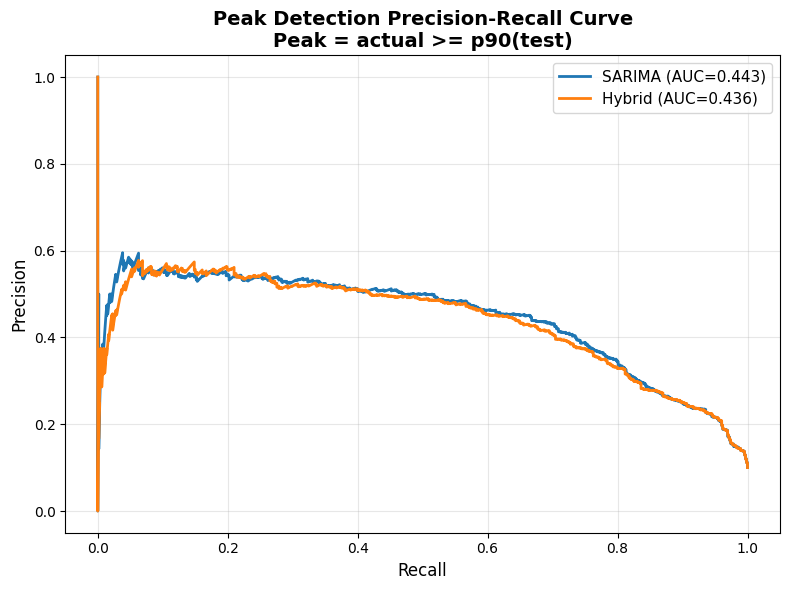

Saved: ../../saved_model_outputs/hybrid_outputs/peak_pr_summary.csv

Peak Detection Summary:
    Model    PR_AUC    BestF1  BestThreshold
0  SARIMA  0.443364  0.537461   50886.769770
1  Hybrid  0.435939  0.525189   51035.666046


In [69]:
# ==============================
# Peak Detection: Precision-Recall Curve Analysis
# ==============================

from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Use the aligned test data
# Define peak threshold (90th percentile of actual demand)
peak_threshold = np.percentile(y_test_actual, 90)
is_peak_eval = y_test_actual >= peak_threshold
y_peak = is_peak_eval.astype(int)

# Get predictions for comparison
sarima_pred_eval = sarima_forecast.loc[hybrid_dates].values
hybrid_pred_eval = y_hybrid_pred

plt.figure(figsize=(8, 6))
pr_summary = []

# SARIMA PR curve
precision_sarima, recall_sarima, thresholds_sarima = precision_recall_curve(y_peak, sarima_pred_eval)
pr_auc_sarima = auc(recall_sarima, precision_sarima)
plt.plot(recall_sarima, precision_sarima, label=f"SARIMA (AUC={pr_auc_sarima:.3f})", linewidth=2)

f1_sarima = 2 * precision_sarima * recall_sarima / (precision_sarima + recall_sarima + 1e-12)
best_idx_sarima = int(np.nanargmax(f1_sarima))
best_f1_sarima = float(f1_sarima[best_idx_sarima])
best_thr_sarima = float(thresholds_sarima[best_idx_sarima-1]) if best_idx_sarima > 0 and best_idx_sarima-1 < len(thresholds_sarima) else np.nan

pr_summary.append({
    "Model": "SARIMA",
    "PR_AUC": pr_auc_sarima,
    "BestF1": best_f1_sarima,
    "BestThreshold": best_thr_sarima
})

# Hybrid PR curve
precision_hybrid, recall_hybrid, thresholds_hybrid = precision_recall_curve(y_peak, hybrid_pred_eval)
pr_auc_hybrid = auc(recall_hybrid, precision_hybrid)
plt.plot(recall_hybrid, precision_hybrid, label=f"Hybrid (AUC={pr_auc_hybrid:.3f})", linewidth=2)

f1_hybrid = 2 * precision_hybrid * recall_hybrid / (precision_hybrid + recall_hybrid + 1e-12)
best_idx_hybrid = int(np.nanargmax(f1_hybrid))
best_f1_hybrid = float(f1_hybrid[best_idx_hybrid])
best_thr_hybrid = float(thresholds_hybrid[best_idx_hybrid-1]) if best_idx_hybrid > 0 and best_idx_hybrid-1 < len(thresholds_hybrid) else np.nan

pr_summary.append({
    "Model": "Hybrid",
    "PR_AUC": pr_auc_hybrid,
    "BestF1": best_f1_hybrid,
    "BestThreshold": best_thr_hybrid
})

plt.title("Peak Detection Precision-Recall Curve\nPeak = actual >= p90(test)", fontsize=14, fontweight='bold')
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../../saved_model_outputs/hybrid_outputs/peak_pr_curve.png", dpi=150, bbox_inches='tight')
plt.show()

pr_summary_df = pd.DataFrame(pr_summary).sort_values("PR_AUC", ascending=False).reset_index(drop=True)
pr_path = "../../saved_model_outputs/hybrid_outputs/peak_pr_summary.csv"
pr_summary_df.to_csv(pr_path, index=False)

print("Saved:", pr_path)
print("\nPeak Detection Summary:")
print(pr_summary_df)


Hybrid Linear Model Coefficients:
  SARIMA weight: 0.6396
  Residual weight: -0.6699
  Intercept: 30845.37

Note: In the actual hybrid model, weights are [1.0, 1.0] with intercept 0.0
This linear approximation helps explain the relative contributions via SHAP.



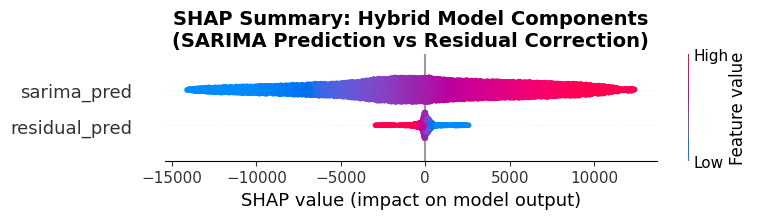

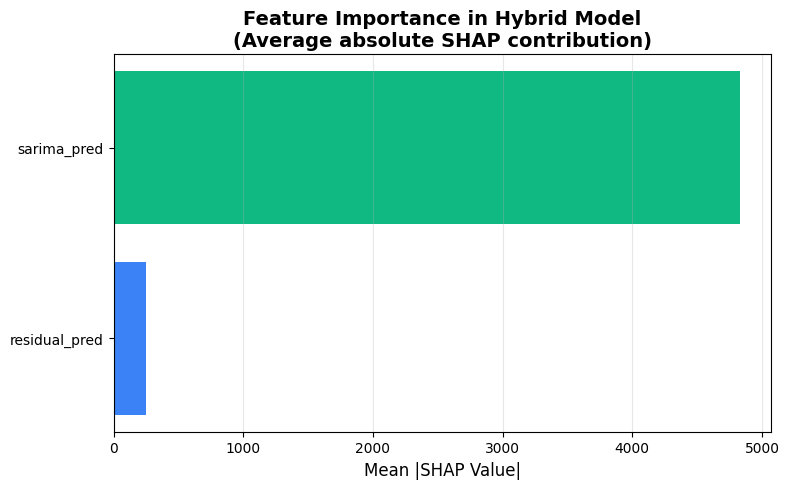


Mean Absolute SHAP Values:
         Feature  Mean |SHAP|
1  residual_pred   251.571224
0    sarima_pred  4828.171768


In [70]:
# ==============================
# SHAP Analysis: Explaining Hybrid Model as Linear Combination
# ==============================

import shap
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Prepare data: Hybrid = SARIMA + Residual
# We'll model Hybrid as a linear combination of SARIMA prediction and residual prediction
feature_names_hybrid = ["sarima_pred", "residual_pred"]

# Create feature matrix: [SARIMA_pred, Residual_pred]
X_hybrid_train = np.column_stack([
    sarima_forecast.loc[hybrid_dates].values,
    resid_pred
])

X_hybrid_eval = X_hybrid_train.copy()  # Using same data for evaluation
y_hybrid_target = y_test_actual

# Fit a simple linear model: Hybrid = w1 * SARIMA + w2 * Residual + b
# This captures how the hybrid model combines SARIMA and residual predictions
hybrid_linear_model = Ridge(alpha=0.01)
hybrid_linear_model.fit(X_hybrid_train, y_hybrid_target)

print("Hybrid Linear Model Coefficients:")
print(f"  SARIMA weight: {hybrid_linear_model.coef_[0]:.4f}")
print(f"  Residual weight: {hybrid_linear_model.coef_[1]:.4f}")
print(f"  Intercept: {hybrid_linear_model.intercept_:.2f}")
print(f"\nNote: In the actual hybrid model, weights are [1.0, 1.0] with intercept 0.0")
print("This linear approximation helps explain the relative contributions via SHAP.\n")

# Create SHAP explainer for the linear model
explainer_hybrid = shap.LinearExplainer(
    hybrid_linear_model,
    X_hybrid_train,
    feature_names=feature_names_hybrid
)

# Compute SHAP values
shap_values_hybrid = explainer_hybrid(X_hybrid_eval)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_hybrid.values,
    X_hybrid_eval,
    feature_names=feature_names_hybrid,
    show=False
)
plt.title("SHAP Summary: Hybrid Model Components\n(SARIMA Prediction vs Residual Correction)", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../../saved_model_outputs/hybrid_outputs/shap_hybrid_summary.png", dpi=150, bbox_inches='tight')
plt.show()

# Bar plot for mean absolute SHAP values
shap_mean_abs = np.abs(shap_values_hybrid.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": feature_names_hybrid,
    "Mean |SHAP|": shap_mean_abs
}).sort_values("Mean |SHAP|", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(shap_df["Feature"], shap_df["Mean |SHAP|"], color=['#3b82f6', '#10b981'])
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.title("Feature Importance in Hybrid Model\n(Average absolute SHAP contribution)", 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("../../saved_model_outputs/hybrid_outputs/shap_hybrid_bar.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nMean Absolute SHAP Values:")
print(shap_df)


Peak Demand Example:
  Time: 2018-01-18 10:00:00+00:00
  Actual demand: 75,964.00 MW
  SARIMA prediction: 57,123.11 MW
  Hybrid prediction: 57,261.20 MW
  Residual correction: 138.09 MW



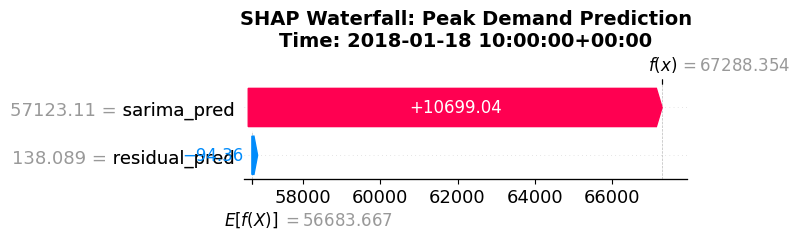


Linear model prediction at this point: 67,288.35 MW
Actual hybrid prediction: 57,261.20 MW
Difference: 10,027.15 MW


In [71]:
# ==============================
# SHAP Waterfall Plot: Peak Demand Example
# ==============================

# Find the time point with maximum actual demand
imax = int(np.argmax(y_test_actual))
max_time = hybrid_dates[imax]
max_actual = float(y_test_actual[imax])
max_hybrid_pred = float(y_hybrid_pred[imax])
max_sarima_pred = float(sarima_forecast.loc[max_time])

print(f"Peak Demand Example:")
print(f"  Time: {max_time}")
print(f"  Actual demand: {max_actual:,.2f} MW")
print(f"  SARIMA prediction: {max_sarima_pred:,.2f} MW")
print(f"  Hybrid prediction: {max_hybrid_pred:,.2f} MW")
print(f"  Residual correction: {max_hybrid_pred - max_sarima_pred:,.2f} MW\n")

# Create SHAP explanation for this specific point
exp_peak = shap.Explanation(
    values=shap_values_hybrid.values[imax],
    base_values=shap_values_hybrid.base_values[imax] if np.ndim(shap_values_hybrid.base_values) else shap_values_hybrid.base_values,
    data=X_hybrid_eval[imax],
    feature_names=feature_names_hybrid
)

# Waterfall plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(exp_peak, max_display=10, show=False)
plt.title(f"SHAP Waterfall: Peak Demand Prediction\nTime: {max_time}", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../../saved_model_outputs/hybrid_outputs/shap_hybrid_waterfall_peak.png", dpi=150, bbox_inches='tight')
plt.show()

# Verify the prediction
fx = float(exp_peak.base_values + np.sum(exp_peak.values))
print(f"\nLinear model prediction at this point: {fx:,.2f} MW")
print(f"Actual hybrid prediction: {max_hybrid_pred:,.2f} MW")
print(f"Difference: {abs(fx - max_hybrid_pred):,.2f} MW")


SHAP Comparison: Peak vs Non-Peak Periods
      Feature  Peak Period |SHAP|  Non-Peak Period |SHAP|  Difference
  sarima_pred         7325.030776             4550.648546 2774.382230
residual_pred          183.478119              259.139700  -75.661581



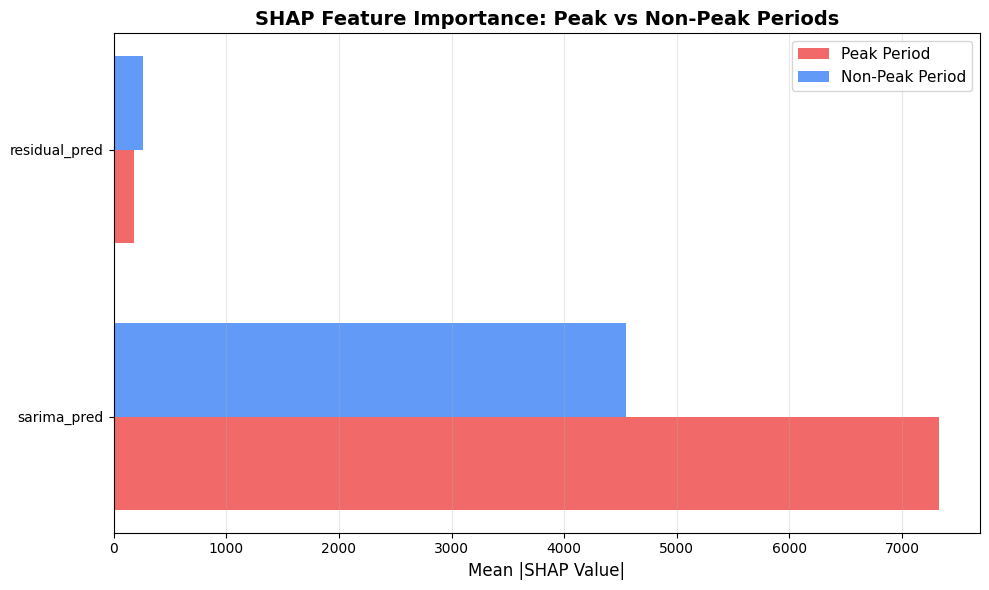

Saved: ../../saved_model_outputs/hybrid_outputs/shap_peak_vs_nonpeak_comparison.csv


In [72]:
# ==============================
# SHAP Comparison: Peak vs Non-Peak Periods
# ==============================

# Identify peak and non-peak periods
is_peak_period = y_test_actual >= peak_threshold

# Compute mean absolute SHAP for peak vs non-peak
shap_peak = np.abs(shap_values_hybrid.values[is_peak_period]).mean(axis=0)
shap_nonpeak = np.abs(shap_values_hybrid.values[~is_peak_period]).mean(axis=0)

comparison_df = pd.DataFrame({
    "Feature": feature_names_hybrid,
    "Peak Period |SHAP|": shap_peak,
    "Non-Peak Period |SHAP|": shap_nonpeak,
    "Difference": shap_peak - shap_nonpeak
}).sort_values("Difference", ascending=False)

print("SHAP Comparison: Peak vs Non-Peak Periods")
print("=" * 60)
print(comparison_df.to_string(index=False))
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(feature_names_hybrid))
width = 0.35

bars1 = ax.barh(x_pos - width/2, shap_peak, width, label='Peak Period', color='#ef4444', alpha=0.8)
bars2 = ax.barh(x_pos + width/2, shap_nonpeak, width, label='Non-Peak Period', color='#3b82f6', alpha=0.8)

ax.set_yticks(x_pos)
ax.set_yticklabels(feature_names_hybrid)
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('SHAP Feature Importance: Peak vs Non-Peak Periods', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig("../../saved_model_outputs/hybrid_outputs/shap_peak_vs_nonpeak_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Save comparison
comparison_df.to_csv("../../saved_model_outputs/hybrid_outputs/shap_peak_vs_nonpeak_comparison.csv", index=False)
print("Saved: ../../saved_model_outputs/hybrid_outputs/shap_peak_vs_nonpeak_comparison.csv")
